In [1]:
# =============================================================================
# IMPORT STATEMENTS - ORGANIZED BY CATEGORY
# =============================================================================

# System and Path Management
import sys
import os
import warnings
import random

# Add custom particles-cdssm path
sys.path.append(os.path.expanduser('~/Desktop/diss_scripts/particles-cdssm'))

# Data Analysis and Numerical Computing
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import acf
from scipy.stats import gaussian_kde, norm, invgamma
from scipy.special import gammaln
from particles.core import SMC
from particles.state_space_models import Bootstrap
from scipy.stats import beta as beta_dist

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Financial Data
import yfinance as yf


# JAX and NumPyro (HMC/NUTS)
import jax
from jax import random
import jax.numpy as jnp
import jax.lax as lax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
from numpyro.diagnostics import effective_sample_size as numpyro_ess

# Particles Package
import particles
from particles import state_space_models as ssm
from particles import mcmc
from particles import distributions
from particles.collectors import Moments
from particles.state_space_models import StochVol, Bootstrap

# Custom Particles CDSSM Collectors
from particles_cdssm.collectors import ObservationPredictiveParticles, ObservationPredictiveMoments, NLPD

# Configuration
warnings.filterwarnings('ignore')

/Users/ac/Desktop/diss_scripts/GITHooo/UCL-Research-Project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data and visualisation

In [2]:
def fetch_sp500_data(start_date="2015-01-01", end_date="2022-01-01"):
    # Download S&P 500 data
    ticker = "SPY"
    data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    
    # Calculate log returns (skip first day as we need previous close)
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1)) * 100
    data = data.dropna() #! remove any potential na's
    
    print(f"Downloaded {len(data)} trading days")
    print(f"Some basic stats: Mean={data['Returns'].mean():.3f}%, Std={data['Returns'].std():.2f}%")
    
    return data

# Fetch the data
data = fetch_sp500_data()


#! Train and test data split
# Function to split data into training and testing sets

def split_data(data, train_ratio=0.8):
    """Split data into training and testing sets"""
    n_total = len(data)
    n_train = int(n_total * train_ratio)
    
    train_data = data.iloc[:n_train].copy()
    test_data = data.iloc[n_train:].copy()
    
    print(f"Data split:")
    print(f"  Training: {len(train_data)} days ({train_data.index[0]} to {train_data.index[-1]})")
    print(f"  Testing:  {len(test_data)} days ({test_data.index[0]} to {test_data.index[-1]})")
    
    return train_data, test_data

# Split the data
train_data, test_data = split_data(data, train_ratio=0.7)
returns_train = train_data['Returns']
returns_test = test_data['Returns']

Downloaded 1762 trading days
Some basic stats: Mean=0.055%, Std=1.12%
Data split:
  Training: 1233 days (2015-01-05 00:00:00 to 2019-11-25 00:00:00)
  Testing:  529 days (2019-11-26 00:00:00 to 2021-12-31 00:00:00)


In [3]:
data.head()

Price,Close,High,Low,Open,Volume,Returns
Ticker,SPY,SPY,SPY,SPY,SPY,
Date,,,,,,
2015-01-05,168.469574,170.682757,168.160567,170.515727,169632600,-1.822466
2015-01-06,166.882767,169.304741,166.081002,168.778583,209151400,-0.946359
2015-01-07,168.962357,169.304778,167.768076,168.219060,125346700,1.238438
2015-01-08,171.960602,172.177753,170.365445,170.382139,147217800,1.758944
2015-01-09,170.582550,172.394858,169.964523,172.378151,158567300,-0.804605


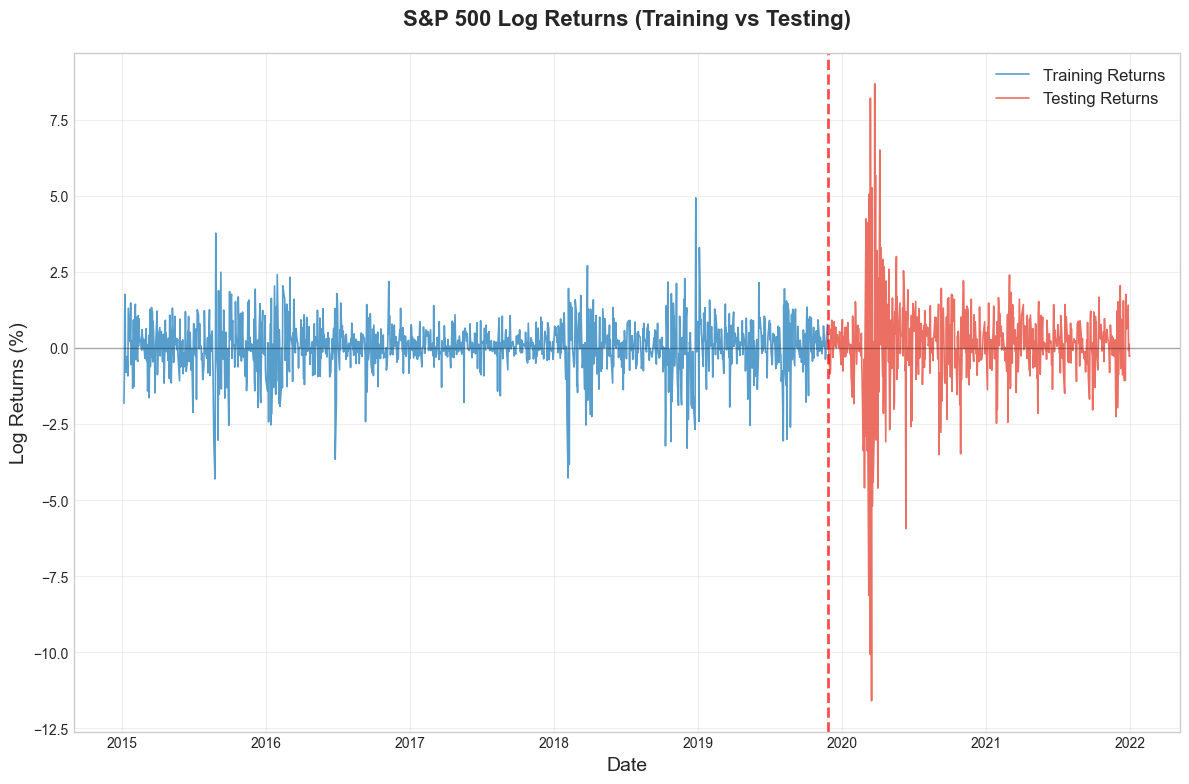


📊 S&P 500 DATA SUMMARY
Total Period: 2015-01-05 to 2021-12-31
Total Trading Days: 1762
Training Split: 1233 days (70.0%)
Testing Split: 529 days (30.0%)

Volatility Clustering Analysis:
Training Period Volatility: 0.853%
Testing Period Volatility: 1.572%

Extreme Days (|returns| > 2%):
Training: 45 days (3.6%)
Testing: 51 days (9.6%)


In [4]:
def plot_sp500_timeseries(data, train_data, test_data):
    """
    Create a beautiful time series visualization of S&P 500 data
    """
    # Set style for beautiful plots
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color scheme
    train_color = '#2E86C1'  # Blue
    test_color = '#E74C3C'   # Red
    price_color = '#27AE60'  # Green
    
    # Calculate split date (boundary between train and test)
    split_date = test_data.index[0]
    
    # Plot: Log Returns - Full Series
    ax.plot(train_data.index, train_data['Returns'], 
                color=train_color, linewidth=1.2, alpha=0.8, label='Training Returns')
    ax.plot(test_data.index, test_data['Returns'], 
                color=test_color, linewidth=1.2, alpha=0.8, label='Testing Returns')
    
    # Add zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    # Add vertical line for split
    ax.axvline(x=split_date, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    ax.set_title('S&P 500 Log Returns (Training vs Testing)', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('Log Returns (%)', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    # Improve date formatting
    ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator((1, 7)))  # Jan and July
    
    # Add summary statistics text box
    train_stats = f"""Training Period Stats:
    Days: {len(train_data)}
    Mean: {train_data['Returns'].mean():.3f}%
    Std: {train_data['Returns'].std():.3f}%
    Min: {train_data['Returns'].min():.2f}%
    Max: {train_data['Returns'].max():.2f}%"""
    
    test_stats = f"""Testing Period Stats:
    Days: {len(test_data)}
    Mean: {test_data['Returns'].mean():.3f}%
    Std: {test_data['Returns'].std():.3f}%
    Min: {test_data['Returns'].min():.2f}%
    Max: {test_data['Returns'].max():.2f}%"""
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3)
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("📊 S&P 500 DATA SUMMARY")
    print("="*60)
    print(f"Total Period: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total Trading Days: {len(data)}")
    print(f"Training Split: {len(train_data)} days ({len(train_data)/len(data):.1%})")
    print(f"Testing Split: {len(test_data)} days ({len(test_data)/len(data):.1%})")
    print("\nVolatility Clustering Analysis:")
    print(f"Training Period Volatility: {train_data['Returns'].std():.3f}%")
    print(f"Testing Period Volatility: {test_data['Returns'].std():.3f}%")
    
    # Calculate some interesting metrics
    train_extreme_days = len(train_data[abs(train_data['Returns']) > 2])
    test_extreme_days = len(test_data[abs(test_data['Returns']) > 2])
    print(f"\nExtreme Days (|returns| > 2%):")
    print(f"Training: {train_extreme_days} days ({train_extreme_days/len(train_data):.1%})")
    print(f"Testing: {test_extreme_days} days ({test_extreme_days/len(test_data):.1%})")

# Usage
plot_sp500_timeseries(data, train_data, test_data)

In [5]:
# ---------- 1) Volatility Clustering View ----------
def plot_volatility_clustering(returns: pd.Series):
    """
    Time series of absolute returns (%) and squared returns ((%)^2).
    Shows bursts and calm periods -> evidence of volatility clustering.
    """
    fig, ax = plt.subplots(figsize=(12, 4.5))
    ax.plot(returns.index, returns.abs(), lw=0.9, alpha=0.85, label='|Returns|')
    ax.plot(returns.index, returns**2, lw=0.9, alpha=0.6, label='Returns^2')
    ax.set_title('Volatility Clustering: |Returns| and Returns^2 over Time')
    ax.set_ylabel('Magnitude (%, or (%)²)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(alpha=0.3)
    return fig, ax

# ---------- 2) Distribution Shape Check ----------
def plot_return_distribution(returns: pd.Series, bins=60):
    """
    Histogram/KDE-style view with a Normal(μ, σ) curve overlaid (same μ, σ as data).
    Quickly reveals fat tails / skew relative to Gaussian.
    """
    mu = returns.mean()
    sigma = returns.std(ddof=1)

    # Build normal curve on support of data
    x = np.linspace(returns.min()*1.2, returns.max()*1.2, 500)
    # normal pdf (manual to avoid extra deps), returns in % units
    norm_pdf = (1 / (sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

    fig, ax = plt.subplots(figsize=(10, 5))
    # density=True so histogram integrates to 1
    ax.hist(returns, bins=bins, density=True, alpha=0.5, edgecolor='none', label='Empirical')
    ax.plot(x, norm_pdf, lw=2, label=f'Normal($\\mu$={mu:.3f}%, $\\sigma$={sigma:.3f}%)')
    ax.set_title('Return Distribution vs Normal Fit')
    ax.set_xlabel('Daily Return (%)')
    ax.set_ylabel('Density')
    ax.grid(alpha=0.3)
    ax.legend()
    return fig, ax

def plot_acf_returns_vs_squared(returns, lags=40):
    """
    Plot ACF of raw returns and squared returns with 95% confidence bands.
    Returns (fig, axes).

    Compatible with recent Matplotlib where ax.stem returns a LineCollection
    (not an iterable) for stemlines.
    """

    # Clean input
    r = np.asarray(returns, dtype=float).ravel()
    r = r[~np.isnan(r)]
    if len(r) < max(10, lags + 1):
        raise ValueError("Not enough non-NaN observations for requested lags.")

    r2 = r ** 2

    # Compute ACFs (includes lag 0)
    acf_r = acf(r, nlags=lags, fft=False)
    acf_r2 = acf(r2, nlags=lags, fft=False)

    # 95% band under white-noise null
    N = len(r)
    band = 1.96 / np.sqrt(N)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), constrained_layout=True)
    data = [(acf_r, 'ACF: Returns'), (acf_r2, 'ACF: Squared Returns')]

    for ax, (vals, title) in zip(axes, data):
        x = np.arange(len(vals))  # 0..lags

        # Stem plot (handle recent Matplotlib API)
        markerline, stemlines, baseline = ax.stem(x, vals, basefmt=" ")

        # Style marker
        try:
            markerline.set_markerfacecolor('C0')
            markerline.set_markersize(4)
        except Exception:
            pass

        # Style stems: LineCollection in newer Matplotlib, iterable of lines in older
        if hasattr(stemlines, "set_color"):
            stemlines.set_color('C0')
            stemlines.set_linewidth(1.2)
            stemlines.set_alpha(1.0)
        else:
            # Fallback for very old versions
            try:
                for ln in stemlines:
                    ln.set_color('C0')
                    ln.set_linewidth(1.2)
            except Exception:
                pass

        # Style baseline if present
        if baseline is not None and hasattr(baseline, "set_color"):
            baseline.set_color('none')

        # Zero line and confidence band
        ax.axhline(0, color='black', linewidth=1)
        ax.axhspan(-band, band, color='C3', alpha=0.15, zorder=0)

        # Axis cosmetics
        ymin = min(vals.min(), -band) - 0.05
        ymax = max(vals.max(), band) + 0.05
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(-0.5, lags + 0.5)
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelation')
        ax.set_title(title, fontsize=14)
        ax.grid(alpha=0.3)

    return fig, axes



# ---------- 4) Rolling Volatility ----------
def plot_rolling_volatility(returns: pd.Series, window: int = 21, trading_days: int = 252):
    """
    Rolling volatility using windowed standard deviation of daily returns (in %),
    annualized by sqrt(252) by default.
    """
    roll_std = returns.rolling(window).std(ddof=1)
    ann_vol = roll_std * np.sqrt(trading_days)

    fig, ax = plt.subplots(figsize=(12, 4.5))
    ax.plot(ann_vol.index, ann_vol, lw=1.2, color='tab:blue')
    ax.set_title(f'Rolling Annualized Volatility ({window}-day window)')
    ax.set_ylabel('Volatility (% per year)')
    ax.set_xlabel('Date')
    ax.grid(alpha=0.3)
    return fig, ax

# ---------- 5) Extreme Move Timeline ----------
def plot_extreme_moves_timeline(returns: pd.Series, threshold: float = 2.0):
    """
    Marks days where |return| exceeds `threshold` percent.
    """
    mask = returns.abs() > threshold
    fig, ax = plt.subplots(figsize=(12, 3.8))
    ax.plot(returns.index, returns, lw=0.7, alpha=0.6, color='gray')
    ax.scatter(returns.index[mask], returns[mask], color='crimson', s=12, zorder=3, label=f'|r| > {threshold}%')
    ax.axhline(threshold, color='crimson', lw=1, ls='--', alpha=0.7)
    ax.axhline(-threshold, color='crimson', lw=1, ls='--', alpha=0.7)
    ax.set_title(f'Extreme Move Timeline (|return| > {threshold}%)')
    ax.set_ylabel('Daily Return (%)')
    ax.set_xlabel('Date')
    ax.grid(alpha=0.3)
    ax.legend()
    return fig, ax




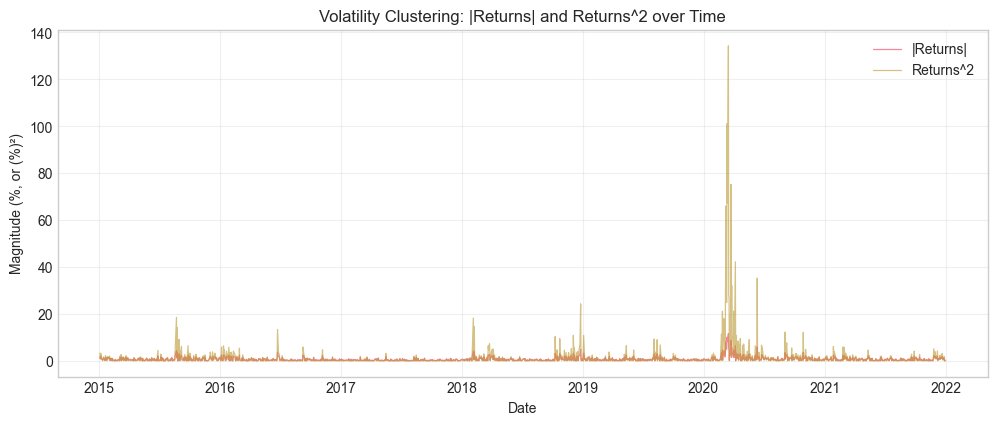

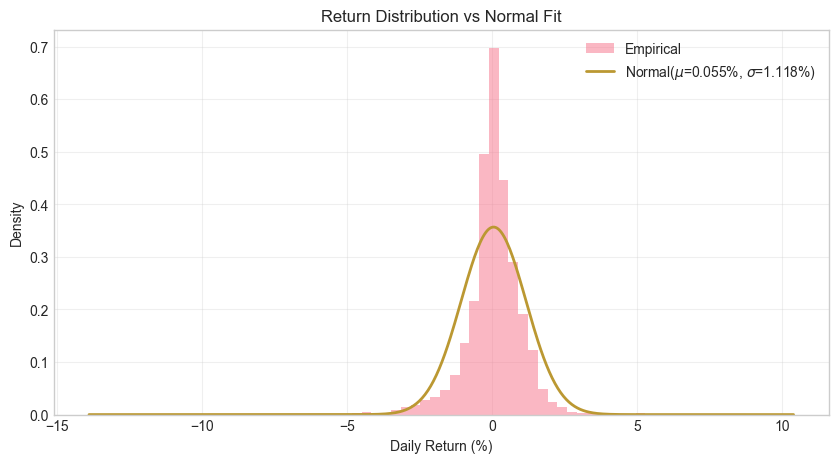

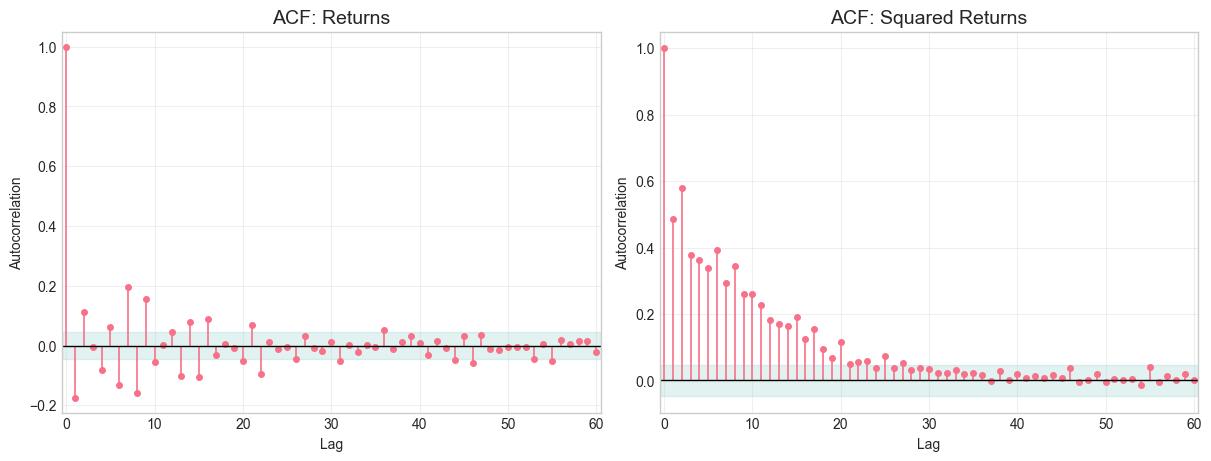

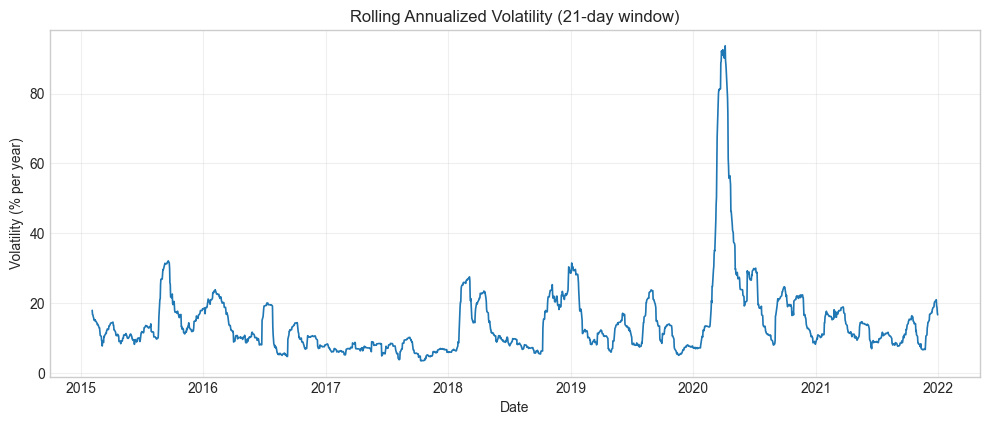

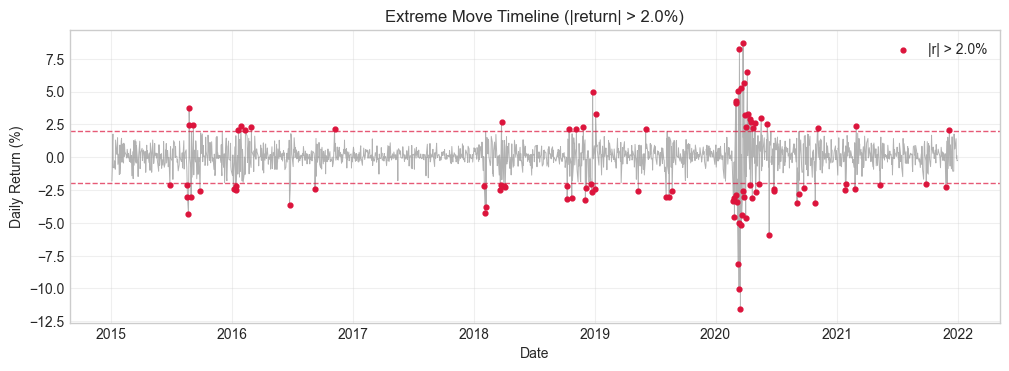

In [6]:
# ---------- Example usage (with your existing data frame) ----------
# Assuming you already have `data` with column 'Returns' (in %) like in your snippet:
r = data['Returns']
plot_volatility_clustering(r)
plot_return_distribution(r)
plot_acf_returns_vs_squared(r, lags=60)
plot_rolling_volatility(r, window=21)
plot_extreme_moves_timeline(r, threshold=2.0)
plt.show()  # if running interactively

# Model Definitions

In [7]:
class StochasticVolatilityModel(ssm.StateSpaceModel):
    """
    Stochastic Volatility Model with logit-transformed φ parameter
    Parameters (μ, logit_phi, σ^2):
    - mu: long-run log-volatility level
    - logit_phi: logit-transformed persistence parameter
    - sigma_x: volatility of log-volatility
    
    Note: phi = exp(logit_phi) / (1 + exp(logit_phi))
    """
    
    def __init__(self, mu=-2.5, logit_phi=2.94, sigma_x=0.3):
        self.mu = mu
        self.logit_phi = logit_phi
        self.sigma_x = sigma_x
        
        # Convert logit_phi back to phi for internal calculations
        self.phi = np.exp(logit_phi) / (1 + np.exp(logit_phi))
        
    def PX0(self):
        """Initial distribution of log-volatility"""
        # Stationary distribution: X_0 ~ N(mu, sigma_x^2 / (1 - phi^2))
        var_stat = self.sigma_x**2 / (1 - self.phi**2)
        return particles.distributions.Normal(loc=self.mu, scale=np.sqrt(var_stat))
    
    def PX(self, t, xp):
        # State transition: X_t | X_{t-1}
        # X_{t-1} = xp
        mean = self.mu + self.phi * (xp - self.mu)
        return particles.distributions.Normal(loc=mean, scale=self.sigma_x)
    
    def PY(self, t, xp, x):
        """Observation distribution: Y_t | X_t"""
        # Y_t = exp(X_t/2) * eta_t where eta_t ~ N(0,1)
        x_bounded = np.clip(x, -15, 5)  # Clip to avoid extreme values
        volatility = np.exp(x_bounded / 2)
        volatility = np.maximum(volatility, 1e-6)  # Avoid zero volatility
        return particles.distributions.Normal(loc=0.0, scale=volatility)

class BlackScholesModel(ssm.StateSpaceModel):
    """
    Simple constant volatility model (Black-Scholes baseline)
    Just returns constant normal distribution - no real dynamics
    """
    def __init__(self, volatility):
        self.volatility = volatility
    
    def PX0(self):
        """Dummy initial state - not really used"""
        return particles.distributions.Normal(loc=0, scale=0.001)
    
    def PX(self, t, xp):
        """Dummy state transition - essentially no change"""
        return particles.distributions.Normal(loc=xp, scale=0.0001)
    
    def PY(self, t, xp, x):
        """Observation model: Y_t ~ N(0, σ²) with constant σ"""
        N = len(x) if hasattr(x, '__len__') else 1
        return particles.distributions.Normal(
            loc=np.zeros(N), 
            scale=self.volatility
        )

def garch_model(returns):
    """
    GARCH(1,1) model for return volatility.
    r_t ~ N(0, sigma_t^2)
    sigma_t^2 = omega + alpha * r_{t-1}^2 + beta * sigma_{t-1}^2
    """
    

    T = returns.shape[0]

    # Priors (set loosely; tune based on domain knowledge or standard GARCH papers)
    omega = numpyro.sample('omega', dist.Exponential(10.0))  # Small positive
    alpha = numpyro.sample('alpha', dist.Beta(2, 5))         # In (0,1)
    beta = numpyro.sample('beta', dist.Beta(5, 2))           # In (0,1)

    # Enforce alpha + beta < 1 for stationarity
    numpyro.factor('stationarity', jnp.where(alpha + beta < 1, 0.0, -1e6))

    # Initial variance
    sigma2_0 = jnp.var(returns)  # Could also be learned
    sigma2 = jnp.zeros(T)
    sigma2 = sigma2.at[0].set(sigma2_0)

    for t in range(1, T):
        sigma2 = sigma2.at[t].set(omega + alpha * returns[t-1]**2 + beta * sigma2[t-1])

    numpyro.deterministic('sigma2', sigma2)

    # Observation model
    numpyro.sample('obs', dist.Normal(0.0, jnp.sqrt(sigma2)), obs=returns)


## Estimation diagnostics

In [8]:
def plot_acf(chain, param_names, max_lags=50):
    """Plot autocorrelation function for MCMC chains"""
    
    
    fig, axes = plt.subplots(1, len(param_names), figsize=(15, 4))
    if len(param_names) == 1:
        axes = [axes]
    
    for i, param in enumerate(param_names):
        # Calculate ACF
        autocorr = acf(chain[:, i], nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i].plot(lags, autocorr, 'b-', linewidth=2)
        axes[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[i].axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='5% threshold')
        axes[i].axhline(y=-0.05, color='r', linestyle='--', alpha=0.7)
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Autocorrelation')
        axes[i].set_title(f'ACF for {param}')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def effective_sample_size(chain):
    """Calculate effective sample size for MCMC chains"""    
    n_samples, n_params = chain.shape
    ess_values = []
    
    for i in range(n_params):
        # Calculate autocorrelation
        max_lags = min(n_samples // 4, 200)  # Don't use too many lags
        try:
            autocorrs = acf(chain[:, i], nlags=max_lags, fft=True)
            
            # Find first negative autocorrelation or where it drops below 0.05
            cutoff = 1
            for lag in range(1, len(autocorrs)):
                if autocorrs[lag] <= 0.05:
                    cutoff = lag
                    break
            
            # Calculate integrated autocorrelation time
            tau_int = 1 + 2 * np.sum(autocorrs[1:cutoff+1])
            
            # Effective sample size
            ess = n_samples / (2 * tau_int)
            ess_values.append(max(ess, 1))  # Ensure ESS is at least 1
            
        except:
            # Fallback calculation
            ess_values.append(n_samples / 10)  # Conservative estimate
    
    return np.array(ess_values)

def mcmc_diagnostics(chain, param_names, burned_chain):
    """Comprehensive MCMC diagnostics"""
    print("\n📊 MCMC Convergence Diagnostics:")
    print("=" * 40)
    
    # Basic chain statistics
    n_total, n_params = chain.shape
    n_burned = len(burned_chain)
    
    print(f"Total iterations: {n_total}")
    print(f"Burn-in samples: {n_total - n_burned}")
    print(f"Post-burn samples: {n_burned}")
    
    # Effective sample size
    ess = effective_sample_size(burned_chain)
    print(f"\nEffective Sample Sizes:")
    for i, param in enumerate(param_names):
        print(f"  {param}: {ess[i]:.1f} ({ess[i]/n_burned:.1%} of total)")
    
    # Plot traces and ACF
    fig, axes = plt.subplots(2, n_params, figsize=(15, 8))
    if n_params == 1:
        axes = axes.reshape(-1, 1)
    
    for i, param in enumerate(param_names):
        # Trace plot
        axes[0, i].plot(chain[:, i], alpha=0.7)
        axes[0, i].axvline(x=n_total-n_burned, color='r', linestyle='--', 
                          label='Burn-in end')
        axes[0, i].set_title(f'Trace: {param}')
        axes[0, i].set_ylabel('Value')
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].legend()
        
        # Density plot
        axes[1, i].hist(burned_chain[:, i], bins=50, density=True, alpha=0.7)
        axes[1, i].set_title(f'Posterior: {param}')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Density')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ACF plots
    plot_acf(burned_chain, param_names)
    
    return ess


## SV Parameter Estimation 

In [9]:
def bayesian_parameter_estimation_numpyro(returns, n_warmup=1000, n_samples=2000, n_chains=4, n_burn=500):
    """
    Bayesian parameter estimation for SV model using NumPyro with NUTS (HMC variant).
    Uses non-centered reparameterization for better mixing.
    """

    
    print(f"🎯 Running NumPyro NUTS estimation ({n_chains} chains, {n_warmup} warmup, {n_samples} samples)...")
    
    # Convert returns to numpy array first (fix for pandas Series)
    returns_np = returns.values.astype(np.float32)  # Use float32 for efficiency
    
    # Empirical mu for prior centering (adjustment for log-returns in decimal)
    emp_mu = np.mean(np.log(returns_np**2 + 1e-16)) + 1.2704  # Bias correction
    print(f"Empirical mu estimate: {emp_mu:.2f}")
    
    # Convert to JAX array
    returns_jax = jnp.array(returns_np)
    
    def sv_model(returns):
        mu = numpyro.sample('mu', dist.Normal(loc=emp_mu, scale=2.0))
        
        # Logit reparam for phi in (0,1)
        logit_phi = numpyro.sample('logit_phi', dist.Normal(loc=2.94, scale=1.0))
        phi = numpyro.deterministic('phi', jnp.exp(logit_phi) / (1 + jnp.exp(logit_phi)))
        
        sigma_x = numpyro.sample('sigma_x', dist.InverseGamma(3, 0.5))
        
        T = returns.shape[0]
        
        # Non-centered: sample i.i.d innovations
        eta = numpyro.sample('eta', dist.Normal(0, 1), sample_shape=(T,))
        
        # Deterministically build h (log-vol) using scan for efficiency
        def build_h(carry, xs):
            t, eta_t = xs
            h_t = mu + phi * (carry - mu) + sigma_x * eta_t
            return h_t, h_t
        
        # Initial h_0 from stationary dist
        h_init = mu + (sigma_x / jnp.sqrt(1 - phi**2 + 1e-10)) * eta[0]  # Avoid div by zero
        
        # Scan over t=1 to T-1
        _, h_rest = jax.lax.scan(build_h, h_init, (jnp.arange(1, T), eta[1:]))
        h = jnp.concatenate([h_init[None], h_rest])
        
        numpyro.deterministic('h', h)
        
        # Observations (decimal returns)
        numpyro.sample('obs', dist.Normal(0.0, jnp.exp(h / 2)), obs=returns)
    
    # Set up NUTS sampler
    nuts_kernel = NUTS(sv_model)
    mcmc = MCMC(nuts_kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, progress_bar=True)
    
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, returns=returns_jax)
    
    # Get samples (dict with 'mu', 'logit_phi', 'sigma_x', etc.; phi is deterministic)
    samples = mcmc.get_samples()
    
    # Compute phi samples from logit_phi
    phi_samples = jnp.exp(samples['logit_phi']) / (1 + jnp.exp(samples['logit_phi']))
    
    # Handle single vs multi-chain shaping
    is_single_chain = (samples['mu'].ndim == 1)
    if is_single_chain:
        burned_mu = samples['mu'][n_burn:]
        burned_phi = phi_samples[n_burn:]
        burned_sigma_x = samples['sigma_x'][n_burn:]
        # Reshape to (1, -1) for consistency in ESS etc.
        burned_mu = burned_mu[None, :]
        burned_phi = burned_phi[None, :]
        burned_sigma_x = burned_sigma_x[None, :]
    else:
        burned_mu = samples['mu'][:, n_burn:]
        burned_phi = phi_samples[:, n_burn:]
        burned_sigma_x = samples['sigma_x'][:, n_burn:]
    
    burned_samples = {
        'mu': burned_mu,
        'phi': burned_phi,
        'sigma_x': burned_sigma_x
    }
    
    # Chain for output (flatten chains)
    burned_chain = jnp.stack([burned_mu, burned_phi, burned_sigma_x], axis=-1).reshape(-1, 3)
    
    param_names = ['mu', 'phi', 'sigma_x']
    
    # Diagnostics: ESS on burned samples (expects shape (chains, samples))
    ess = {p: numpyro_ess(burned_samples[p]) for p in param_names}
    ess_values = [ess[p] for p in param_names]
    print("\n📊 MCMC Convergence Diagnostics:")
    print(f"Effective Sample Sizes: {ess}")
    
    # Traces and ACF use full samples (adjust for single chain)
    if is_single_chain:
        mu_full = samples['mu'][None, :]
        phi_full = phi_samples[None, :]
        sigma_x_full = samples['sigma_x'][None, :]
    else:
        mu_full = samples['mu']
        phi_full = phi_samples
        sigma_x_full = samples['sigma_x']
    
    full_samples_for_plot = {
        'mu': mu_full,
        'phi': phi_full,
        'sigma_x': sigma_x_full
    }
    
    for i, param in enumerate(param_names):
        param_samples = full_samples_for_plot[param]
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(param_samples.T, alpha=0.5)
        plt.title(f'Trace: {param}')
        plt.axvline(n_burn, color='r', linestyle='--')
        
        plt.subplot(1, 2, 2)
        lags = np.arange(50)
        autocorr = acf(param_samples.mean(axis=0), nlags=49)  # Avg over chains
        plt.plot(lags, autocorr)
        plt.axhline(0.05, color='r', linestyle='--')
        plt.axhline(-0.05, color='r', linestyle='--')
        plt.title(f'ACF: {param}')
        plt.show()
    
    # Parameter estimates from burned_chain
    param_estimates = {
        param: {'mean': jnp.mean(burned_chain[:, i]), 'std': jnp.std(burned_chain[:, i])}
        for i, param in enumerate(param_names)
    }
    
    # Also store logit_phi
    if is_single_chain:
        logit_phi_burned = samples['logit_phi'][n_burn:]
    else:
        logit_phi_burned = samples['logit_phi'][:, n_burn:].reshape(-1)
    logit_phi_estimates = {
        'mean': jnp.mean(logit_phi_burned),
        'std': jnp.std(logit_phi_burned)
    }
    
    return {
        'chain': jnp.stack([burned_mu, burned_phi, burned_sigma_x], axis=-1),
        'burned_chain': burned_chain,
        'estimates': param_estimates,
        'logit_phi_estimates': logit_phi_estimates,
        'effective_sample_size': ess_values,
        'param_names': param_names,
        'mcmc': mcmc  # For further inspection
    }

### Execution script

📊 Step 1: Loading and preprocessing S&P 500 data...
Downloaded 1762 trading days
Some basic stats: Mean=0.055%, Std=1.12%
Data split:
  Training: 1233 days (2015-01-05 00:00:00 to 2019-11-25 00:00:00)
  Testing:  529 days (2019-11-26 00:00:00 to 2021-12-31 00:00:00)
✓ Data preprocessing completed

⛓️  Step 2: Running Bayesian parameter estimation with NUTS...
🎯 Running NumPyro NUTS estimation (4 chains, 5000 warmup, 20000 samples)...
Empirical mu estimate: -10.28


sample: 100%|██████████| 25000/25000 [00:46<00:00, 541.90it/s, 31 steps of size 1.14e-01. acc. prob=0.88]



📊 MCMC Convergence Diagnostics:
Effective Sample Sizes: {'mu': 35951.87492505069, 'phi': 19030.31545850715, 'sigma_x': 19116.555355984223}


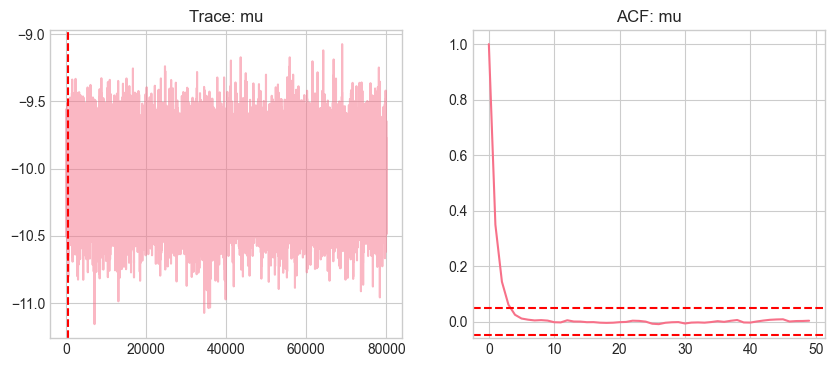

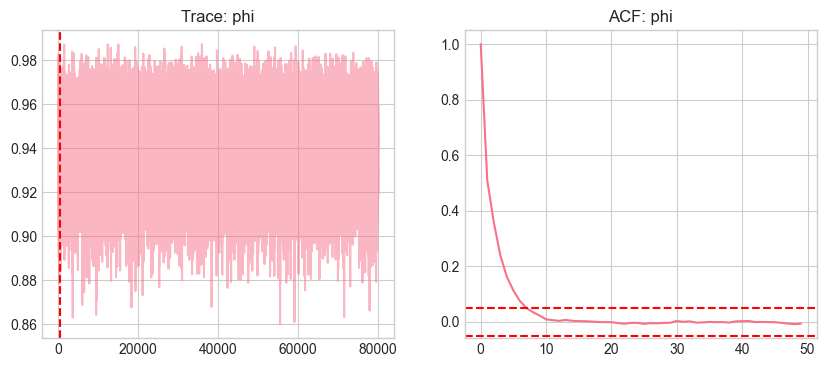

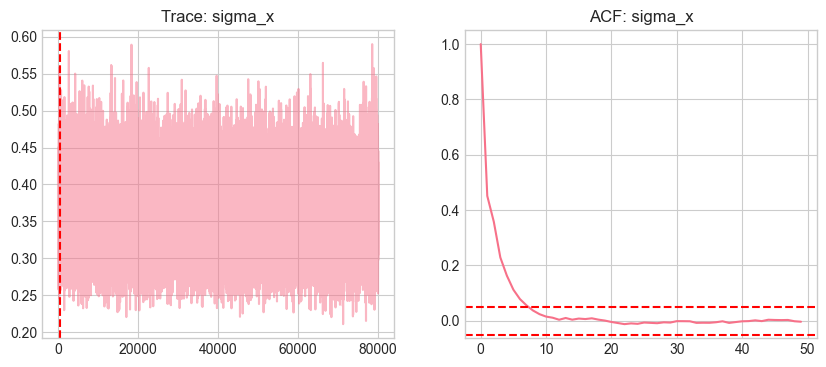

✓ MCMC parameter estimation completed


In [10]:
# =============================================================================
# MAIN EXECUTION SCRIPT
# =============================================================================

# Step 1: Data Loading and Preprocessing
print("📊 Step 1: Loading and preprocessing S&P 500 data...")
data = fetch_sp500_data(start_date="2015-01-01", end_date="2022-01-01")
train_data, test_data = split_data(data, train_ratio=0.7)
returns_train = train_data['Returns']
returns_test = test_data['Returns']

# Convert percentage returns to decimal returns for modeling
train_data_decimal = train_data.copy()
train_data_decimal['Returns'] = returns_train / 100
returns_train_decimal = returns_train / 100

test_data_decimal = test_data.copy()
test_data_decimal['Returns'] = returns_test / 100
returns_test_decimal = returns_test / 100

print("✓ Data preprocessing completed")

# Step 2: Bayesian Parameter Estimation with HMC
print("\n⛓️  Step 2: Running Bayesian parameter estimation with NUTS...")
mcmc_results = bayesian_parameter_estimation_numpyro(
    returns_train_decimal, 
    n_warmup=5000, 
    n_samples=20000
)
print("✓ MCMC parameter estimation completed")

## GARCH Parameter Estimation

In [11]:
def bayesian_garch_estimation_numpyro(returns, n_warmup=1000, n_samples=2000, n_chains=4):
    """
    Run HMC on GARCH(1,1) model using NumPyro with better initialization.
    """

    print(f"🎯 Running GARCH estimation ({n_chains} chains, {n_warmup} warmup, {n_samples} samples)...")
    
    returns_np = returns.values.astype(np.float32) if hasattr(returns, 'values') else returns.astype(np.float32)
    returns_jax = jnp.array(returns_np)
    
    # Calculate empirical values for initialization
    emp_var = jnp.var(returns_jax)
    print(f"Empirical variance: {emp_var:.6f}")
    
    def garch_model(returns):
        T = returns.shape[0]
        
        # Better priors based on typical GARCH values
        omega = numpyro.sample('omega', dist.Uniform(1e-6, 0.01))
        alpha = numpyro.sample('alpha', dist.Beta(2, 5))  # Mean ~0.28
        beta = numpyro.sample('beta', dist.Beta(5, 2))   # Mean ~0.71
        
        # Soft constraint for stationarity (alpha + beta < 0.999)
        sum_ab = alpha + beta
        numpyro.factor('stationarity', jnp.where(sum_ab < 0.999, 0.0, -100 * (sum_ab - 0.999)**2))
        
        # Initialize variance 
        sigma2_init = omega / (1 - alpha - beta + 1e-10)
        
        def garch_step(carry, t):
            sigma2_prev = carry
            # GARCH update with numerical stability
            sigma2_t = omega + alpha * returns[t-1]**2 + beta * sigma2_prev
            sigma2_t = jnp.maximum(sigma2_t, 1e-10)  # Ensure positive
            return sigma2_t, sigma2_t
        
        # Use scan for efficiency
        _, sigma2_rest = jax.lax.scan(
            garch_step, 
            sigma2_init, 
            jnp.arange(1, T)
        )
        
        # Combine initial and rest
        sigma2 = jnp.concatenate([sigma2_init[None], sigma2_rest])
        
        # Store for diagnostics
        numpyro.deterministic('sigma2', sigma2)
        
        # Likelihood with numerical stability
        sigma = jnp.sqrt(jnp.maximum(sigma2, 1e-10))
        numpyro.sample('obs', dist.Normal(0.0, sigma), obs=returns)
    
    # Initialize with reasonable values
    init_values = {
        'omega': emp_var * 0.05,  # Small fraction of variance
        'alpha': 0.1,
        'beta': 0.85
    }
    
    print(f"Initial values: omega={init_values['omega']:.6f}, alpha={init_values['alpha']}, beta={init_values['beta']}")
    
    # Set up NUTS with initialization
    nuts_kernel = NUTS(garch_model, init_strategy=init_to_value(values=init_values))
    mcmc = MCMC(
        nuts_kernel, 
        num_warmup=n_warmup, 
        num_samples=n_samples, 
        num_chains=n_chains, 
        progress_bar=True,
        chain_method='parallel' if n_chains > 1 else 'sequential'
    )
    
    rng_key = random.PRNGKey(42)
    
    try:
        mcmc.run(rng_key, returns=returns_jax)
    except Exception as e:
        print(f"Error during MCMC: {e}")
        print("Trying with sequential chains...")
        mcmc = MCMC(
            nuts_kernel, 
            num_warmup=n_warmup, 
            num_samples=n_samples, 
            num_chains=1,  # Run single chain if parallel fails
            progress_bar=True
        )
        mcmc.run(rng_key, returns=returns_jax)
    
    samples = mcmc.get_samples()
    
    # Check if we got samples
    if samples is None or 'omega' not in samples:
        print("❌ MCMC failed to produce samples")
        return None
    
    sigma2_samples = samples.get('sigma2', None)
    
    # Estimate posterior means for parameters
    param_names = ['omega', 'alpha', 'beta']
    param_estimates = {}
    for name in param_names:
        if name in samples:
            param_estimates[name] = {
                'mean': float(jnp.mean(samples[name])),
                'std': float(jnp.std(samples[name]))
            }
    
    # Effective sample size
    ess = {}
    for name in param_names:
        if name in samples:
            try:
                ess[name] = float(numpyro_ess(samples[name]))
            except:
                ess[name] = 0.0
    
    print("\n📊 GARCH MCMC Estimates:")
    for name in param_names:
        if name in param_estimates:
            mean = param_estimates[name]['mean']
            std = param_estimates[name]['std']
            print(f"{name}: {mean:.6f} ± {std:.6f} (ESS: {ess.get(name, 0):.1f})")
    
    # Check stationarity
    if 'alpha' in param_estimates and 'beta' in param_estimates:
        persistence = param_estimates['alpha']['mean'] + param_estimates['beta']['mean']
        print(f"Persistence (α + β): {persistence:.4f}")
        if persistence >= 1:
            print("⚠️ Warning: Model is non-stationary (α + β ≥ 1)")
    
    return {
        'samples': samples,
        'mcmc': mcmc,
        'estimates': param_estimates,
        'ess': ess,
        'sigma2_chain': sigma2_samples if sigma2_samples is not None else None
    }

### Execution Script

In [12]:
# Call it just like your SV estimator:
garch_results = bayesian_garch_estimation_numpyro(
    returns_train_decimal,
    n_warmup=1000,
    n_samples=2000,
    n_chains=4
)
# Extract GARCH volatility estimates for the training period
garch_sigma2_posterior = garch_results['sigma2_chain']
garch_vol_train = np.sqrt(np.mean(garch_sigma2_posterior, axis=0)) * 100  # Convert to percentage

print(f"\n📊 GARCH Volatility Statistics (Training Period):")
print(f"  Mean volatility: {garch_vol_train.mean():.2f}%")
print(f"  Min volatility: {garch_vol_train.min():.2f}%")
print(f"  Max volatility: {garch_vol_train.max():.2f}%")

🎯 Running GARCH estimation (4 chains, 1000 warmup, 2000 samples)...
Empirical variance: 0.000073
Initial values: omega=0.000004, alpha=0.1, beta=0.85


sample: 100%|██████████| 3000/3000 [00:01<00:00, 1664.35it/s, 1 steps of size 2.36e-01. acc. prob=0.94] 



📊 GARCH MCMC Estimates:
omega: 0.000005 ± 0.000001 (ESS: 0.0)
alpha: 0.207578 ± 0.027860 (ESS: 0.0)
beta: 0.737557 ± 0.028725 (ESS: 0.0)
Persistence (α + β): 0.9451

📊 GARCH Volatility Statistics (Training Period):
  Mean volatility: 0.80%
  Min volatility: 0.44%
  Max volatility: 2.73%


In [13]:
def plot_mcmc_diagnostics(results, model_name="Model"):
    """
    Plot trace plots and ACF for MCMC diagnostics
    """
    
    # Determine if it's SV or GARCH based on the results structure
    if 'burned_chain' in results:  # SV model
        chain = results['burned_chain']
        param_names = results['param_names']
        n_params = chain.shape[1]
    else:  # GARCH model
        samples = results['samples']
        param_names = ['omega', 'alpha', 'beta']
        n_params = len(param_names)
    
    # Create figure with trace plots and ACF
    fig, axes = plt.subplots(n_params, 2, figsize=(12, 3*n_params))
    if n_params == 1:
        axes = axes.reshape(1, -1)
    
    for i, param in enumerate(param_names):
        # Get samples for this parameter
        if 'burned_chain' in results:  # SV
            param_samples = chain[:, i]
        else:  # GARCH
            param_samples = samples[param].flatten()
        
        # Trace plot
        axes[i, 0].plot(param_samples, alpha=0.7, linewidth=0.5, color='blue')
        axes[i, 0].set_title(f'Trace: {param}')
        axes[i, 0].set_xlabel('Iteration')
        axes[i, 0].set_ylabel('Value')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].axhline(np.mean(param_samples), color='red', linestyle='--', alpha=0.5)
        
        # ACF plot
        max_lags = min(50, len(param_samples)//4)
        autocorr = acf(param_samples, nlags=max_lags, fft=True)
        lags = np.arange(len(autocorr))
        
        axes[i, 1].bar(lags, autocorr, color='blue', alpha=0.7)
        axes[i, 1].axhline(0, color='black', linewidth=0.5)
        axes[i, 1].axhline(0.05, color='red', linestyle='--', alpha=0.5)
        axes[i, 1].axhline(-0.05, color='red', linestyle='--', alpha=0.5)
        axes[i, 1].set_title(f'ACF: {param}')
        axes[i, 1].set_xlabel('Lag')
        axes[i, 1].set_ylabel('Autocorrelation')
        axes[i, 1].set_ylim(-0.2, 1.0)
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{model_name} MCMC Diagnostics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_posterior_distributions(results, model_name="Model"):
    """
    Plot posterior distributions for all parameters
    """
    # Determine if it's SV or GARCH
    if 'burned_chain' in results:  # SV model
        chain = results['burned_chain']
        param_names = results['param_names']
        n_params = chain.shape[1]
    else:  # GARCH model
        samples = results['samples']
        param_names = ['omega', 'alpha', 'beta']
        n_params = len(param_names)
    
    # Create figure
    fig, axes = plt.subplots(1, n_params, figsize=(5*n_params, 4))
    if n_params == 1:
        axes = [axes]
    
    for i, param in enumerate(param_names):
        # Get samples
        if 'burned_chain' in results:  # SV
            param_samples = chain[:, i]
        else:  # GARCH
            param_samples = samples[param].flatten()
        
        # Plot histogram
        axes[i].hist(param_samples, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
        axes[i].axvline(np.mean(param_samples), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {np.mean(param_samples):.4f}')
        axes[i].axvline(np.median(param_samples), color='green', linestyle='--', linewidth=2,
                       label=f'Median: {np.median(param_samples):.4f}')
        axes[i].set_title(f'{param}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle(f'{model_name} Posterior Distributions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 {model_name} Posterior Summary:")
    print("-" * 40)
    for i, param in enumerate(param_names):
        if 'burned_chain' in results:  # SV
            param_samples = chain[:, i]
        else:  # GARCH
            param_samples = samples[param].flatten()
        
        print(f"{param:8s}: {np.mean(param_samples):.4f} ± {np.std(param_samples):.4f}")


GARCH MODEL DIAGNOSTICS


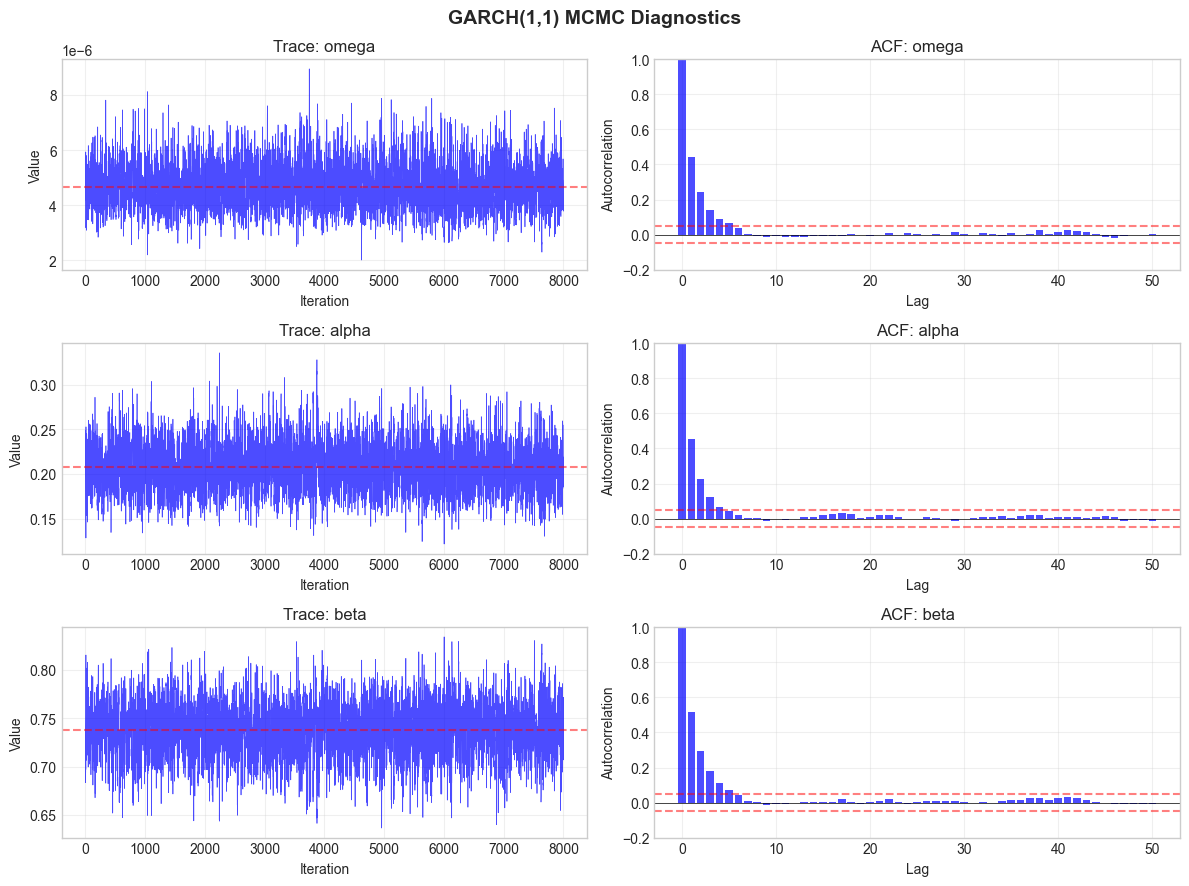

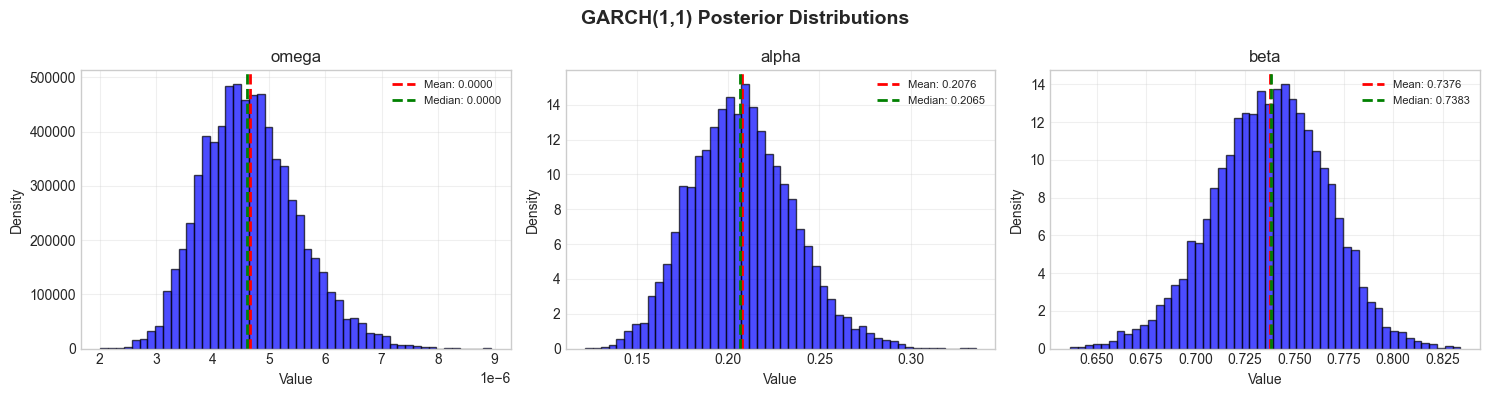


📊 GARCH(1,1) Posterior Summary:
----------------------------------------
omega   : 0.0000 ± 0.0000
alpha   : 0.2076 ± 0.0279
beta    : 0.7376 ± 0.0287


In [14]:
# For GARCH model
print("\n" + "="*60)
print("GARCH MODEL DIAGNOSTICS")
print("="*60)
plot_mcmc_diagnostics(garch_results, "GARCH(1,1)")
plot_posterior_distributions(garch_results, "GARCH(1,1)")

# Online predictions

In [15]:
# =============================================================================
# HELPER FUNCTIONS FOR PARAMETER TRANSFORMATIONS
# =============================================================================

def phi_to_logit_phi(phi):
    """
    Convert phi to logit_phi transformation
    
    Parameters:
    -----------
    phi : float or array
        Persistence parameter in (0, 1)
        
    Returns:
    --------
    logit_phi : float or array
        Logit-transformed phi parameter
    """
    return np.log(phi / (1 - phi))


In [16]:
# =============================================================================
# ONLINE PREDICTION FUNCTIONS
# =============================================================================

def run_online_predictions(train_data, test_data, mcmc_results, N=1000, K=1):
    """
    Run online adaptive predictions using particle filter with predictive collectors
    
    Parameters:
    -----------
    train_data : pd.DataFrame
        Training data with 'Returns' column
    test_data : pd.DataFrame
        Test data with 'Returns' column
    mcmc_results : dict
        Results from MCMC parameter estimation
    N : int, default=1000
        Number of particles
    K : int, default=1
        Number of steps ahead to predict (1 for next-day volatility)
        
    Returns:
    --------
    dict : Dictionary containing online prediction results
    """
    print(f"🎯 Running online adaptive predictions with {N} particles, {K}-step ahead...")
    
    # Get estimated parameters from MCMC
    mu_est = mcmc_results['estimates']['mu']['mean']
    phi_est = mcmc_results['estimates']['phi']['mean']  # This is already phi, not logit_phi
    sigma_x_est = mcmc_results['estimates']['sigma_x']['mean']
    
    print(f"Using parameters: μ={mu_est:.3f}, φ={phi_est:.3f}, σ_x={sigma_x_est:.3f}")
    
    # Combine training and test data for online learning
    all_returns = pd.concat([train_data['Returns'], test_data['Returns']])
    y_data = all_returns.values
    n_train = len(train_data)
    n_total = len(all_returns)
    
    print(f"Total data points: {n_total} (train: {n_train}, test: {n_total - n_train})")
    
    # Create SV model with estimated parameters
    # Note: We need to convert back to logit_phi for the model
    logit_phi_est = phi_to_logit_phi(phi_est)
    ssm = StochasticVolatilityModel(mu=mu_est, logit_phi=logit_phi_est, sigma_x=sigma_x_est)
    
    # Create bootstrap Feynman-Kac model
    fk = Bootstrap(ssm=ssm, data=y_data)    
    
    # Define collectors for different types of predictions
    collectors = [
        ObservationPredictiveParticles(K=K),  # Full particle distributions
        ObservationPredictiveMoments(K=K),    # Just means and variances
        NLPD(K=K)                             # Negative log predictive density
    ]
    
    # Run SMC with predictive collectors
    print("🚀 Starting online SMC with predictive collectors...")
    smc_algo = particles.SMC(fk=fk, N=N, collect=collectors, store_history=True)
    smc_algo.run()
    print("✓ Online SMC completed")
    
    # Extract predictions
    print("📊 Extracting predictions...")
    
    # Get predictive particles (full distributions)
    predictive_particles = smc_algo.summaries.obs_predictive_particles
    
    # Get predictive moments (means and variances)
    predictive_moments = smc_algo.summaries.obs_predictive_moments
    
    # Get NLPD scores
    nlpd_scores = smc_algo.summaries.nlpd
    
    # Convert to volatility estimates
    # The predictions are for returns, we need to convert to volatility
    online_vol_estimates = []
    
    for t in range(len(predictive_moments)):
        if t >= n_train:  # Only for test period
            # Get predictive variance of returns
            pred_var = predictive_moments[t]['var']
            # Convert to annualized volatility percentage
            pred_vol = np.sqrt(pred_var) * np.sqrt(252) * 100  # Return var → daily vol → annual vol
            online_vol_estimates.append(pred_vol)
    
    online_vol_estimates = np.array(online_vol_estimates)
    
    print(f"✓ Generated {len(online_vol_estimates)} online volatility predictions")
    print(f"  Range: {online_vol_estimates.min():.1f}% - {online_vol_estimates.max():.1f}%")
    print(f"  Mean: {online_vol_estimates.mean():.1f}%")
    
    return {
        'online_vol_estimates': online_vol_estimates,
        'predictive_particles': predictive_particles,
        'predictive_moments': predictive_moments,
        'nlpd_scores': nlpd_scores,
        'smc_algo': smc_algo,
        'n_train': n_train
    }
    


In [17]:
def run_garch_forward_predictions(train_data, test_data, garch_results):
    """
    Run rolling 1-step ahead predictions using estimated GARCH parameters (no particles needed).
    """
    print("🔁 Running rolling GARCH(1,1) predictions...")

    omega = garch_results['estimates']['omega']['mean']
    alpha = garch_results['estimates']['alpha']['mean']
    beta = garch_results['estimates']['beta']['mean']
    
    # Start with last training return and last training variance
    train_returns = train_data['Returns'].values
    test_returns = test_data['Returns'].values
    all_returns = np.concatenate([train_returns, test_returns])
    
    # Initialize from training set
    r_prev = train_returns[-1]
    sigma2_prev = np.var(train_returns)  # Or use: omega / (1 - alpha - beta)

    pred_means = []
    pred_vars = []

    for r_true in test_returns:
        # Predict 1-step ahead variance
        sigma2_t = omega + alpha * r_prev**2 + beta * sigma2_prev
        sigma2_t = max(sigma2_t, 1e-10)

        pred_means.append(0.0)  # GARCH assumes E[return] = 0
        pred_vars.append(sigma2_t)

        # Update for next step
        r_prev = r_true
        sigma2_prev = sigma2_t

    pred_means = np.array(pred_means)
    pred_stds = np.sqrt(pred_vars)

    return {
        'pred_mean': pred_means,
        'pred_std': pred_stds,
        'pred_var': pred_vars,
    }


In [18]:
# =============================================================================
# ONLINE PREDICTIONS EXECUTION
# =============================================================================

print("📊 Step 3.5: Running online predictions...")

# Run online predictions using estimated parameters
online_results = run_online_predictions(
    train_data_decimal, 
    test_data_decimal, 
    mcmc_results, 
    N=1000, 
    K=1
)

# =============================================================================
# GARCH ONLINE PREDICTIONS EXECUTION
# =============================================================================

print("\n📊 Step 3.6: Running GARCH online predictions...")

# Run GARCH online predictions
garch_online_results = run_garch_forward_predictions(
    train_data_decimal, 
    test_data_decimal, 
    garch_results
)

print("✓ GARCH online predictions completed")


📊 Step 3.5: Running online predictions...
🎯 Running online adaptive predictions with 1000 particles, 1-step ahead...
Using parameters: μ=-10.075, φ=0.943, σ_x=0.360
Total data points: 1762 (train: 1233, test: 529)
🚀 Starting online SMC with predictive collectors...
✓ Online SMC completed
📊 Extracting predictions...
✓ Generated 530 online volatility predictions
  Range: 6.6% - 86.3%
  Mean: 17.2%

📊 Step 3.6: Running GARCH online predictions...
🔁 Running rolling GARCH(1,1) predictions...
✓ GARCH online predictions completed


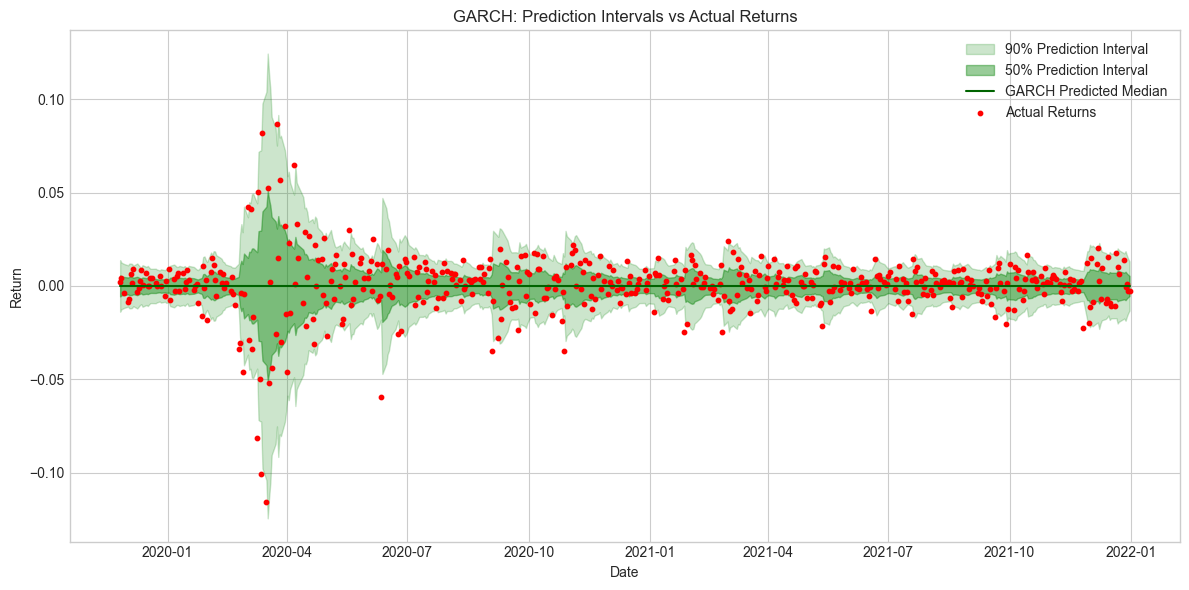

In [19]:
def plot_garch_online_predictions(test_data_decimal, garch_online_results):
    """
    Plot GARCH online predictions: 50% and 90% prediction intervals vs actual returns.
    """

    # Extract from inputs
    dates = test_data_decimal.index
    actual_returns = test_data_decimal['Returns'].values  # Decimal returns
    pred_mean = garch_online_results['pred_mean']
    pred_std = garch_online_results['pred_std']

    # Prediction intervals
    upper_90 = pred_mean + 1.64 * pred_std
    lower_90 = pred_mean - 1.64 * pred_std
    upper_50 = pred_mean + 0.67 * pred_std
    lower_50 = pred_mean - 0.67 * pred_std

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.fill_between(dates, lower_90, upper_90, color='green', alpha=0.2, label='90% Prediction Interval')
    plt.fill_between(dates, lower_50, upper_50, color='green', alpha=0.4, label='50% Prediction Interval')
    plt.plot(dates, pred_mean, color='darkgreen', label='GARCH Predicted Median')
    plt.scatter(dates, actual_returns, color='red', s=10, label='Actual Returns')

    plt.title("GARCH: Prediction Intervals vs Actual Returns")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_garch_online_predictions(test_data_decimal, garch_online_results)


📊 Step 4: Creating return distribution visualizations...
1. Predictive distributions at selected time points:


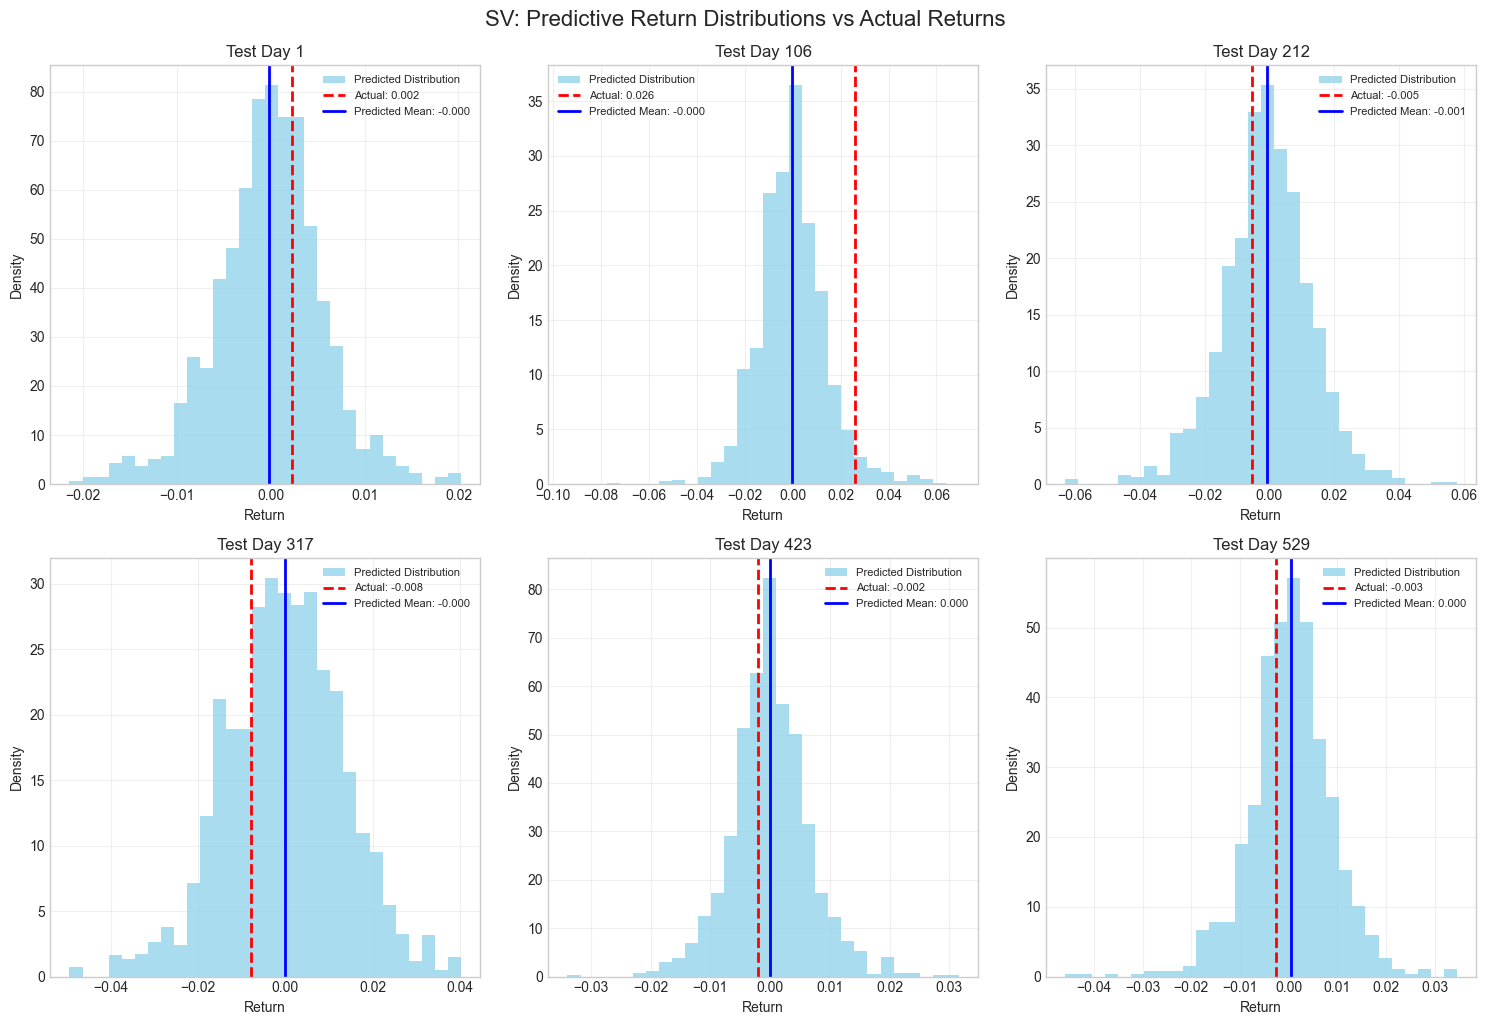

2. Prediction intervals and coverage:


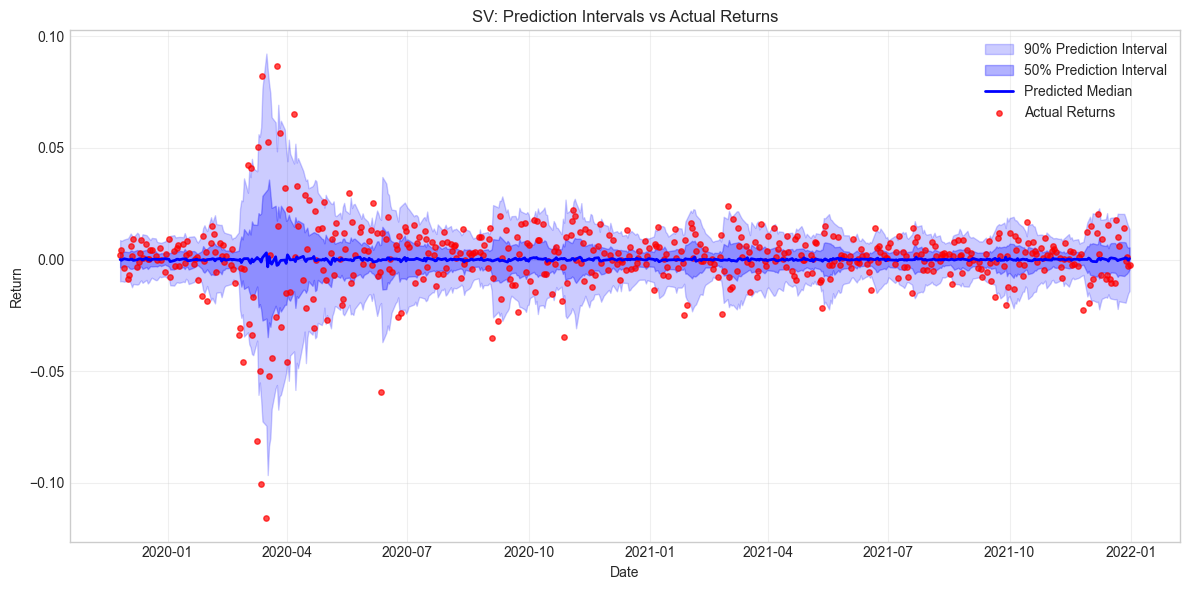

SV Prediction Interval Coverage:
  90% interval: 88.1% (target: 90%)
  50% interval: 43.9% (target: 50%)


In [20]:
# =============================================================================
# VISUALIZATION EXECUTION (CORRECTED)
# =============================================================================

print("📊 Step 4: Creating return distribution visualizations...")

# Extract data from online results
predictive_particles = online_results['predictive_particles']
n_train = online_results['n_train']

# Get actual test returns only
actual_test_returns = test_data_decimal['Returns'].values

# 1. Distribution snapshots at different time points
print("1. Predictive distributions at selected time points:")

# Create a modified version of plot_return_distributions for proper indexing
def plot_sv_return_distributions(predictive_particles, actual_test_returns, n_train, n_examples=6):
    """
    Plot SV predictive return distributions vs actual returns with correct indexing
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Select time points from the TEST period
    # predictive_particles[n_train] corresponds to first test observation
    test_start = n_train
    test_end = min(len(predictive_particles), n_train + len(actual_test_returns))
    
    # Select evenly spaced points in test period
    time_points = np.linspace(test_start, test_end-1, n_examples, dtype=int)
    
    for i, t in enumerate(time_points):
        if t < len(predictive_particles) and predictive_particles[t] is not None:
            # Get predictive particles for time t
            weights, particles = predictive_particles[t]
            
            # Calculate actual test index
            test_idx = t - n_train
            
            if test_idx < len(actual_test_returns):
                # Plot predictive distribution
                axes[i].hist(particles, bins=30, density=True, alpha=0.7, 
                            label='Predicted Distribution', color='skyblue', weights=weights.W)
                
                # Add actual return as vertical line
                axes[i].axvline(actual_test_returns[test_idx], color='red', linestyle='--', linewidth=2,
                               label=f'Actual: {actual_test_returns[test_idx]:.3f}')
                
                # Add predicted mean
                pred_mean = np.average(particles, weights=weights.W)
                axes[i].axvline(pred_mean, color='blue', linestyle='-', linewidth=2,
                               label=f'Predicted Mean: {pred_mean:.3f}')
                
                axes[i].set_title(f'Test Day {test_idx+1}')
                axes[i].set_xlabel('Return')
                axes[i].set_ylabel('Density')
                axes[i].legend(fontsize=8)
                axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('SV: Predictive Return Distributions vs Actual Returns', y=1.02, fontsize=16)
    plt.show()

plot_sv_return_distributions(predictive_particles, actual_test_returns, n_train)

# 2. Quantile-based analysis
print("2. Prediction intervals and coverage:")

def plot_sv_quantile_analysis(predictive_particles, actual_test_returns, test_data_decimal, n_train):
    """
    Analyze SV prediction quality using quantiles with correct indexing
    """
    # Calculate prediction intervals for test period
    quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    pred_quantiles = {q: [] for q in quantiles}
    valid_dates = []
    valid_actual_returns = []
    
    # Loop through test period predictions
    for t in range(n_train, min(len(predictive_particles), n_train + len(actual_test_returns))):
        if predictive_particles[t] is not None:
            weights, particles = predictive_particles[t]
            test_idx = t - n_train
            
            # Calculate weighted quantiles
            sorted_idx = np.argsort(particles)
            sorted_particles = particles[sorted_idx]
            sorted_weights = weights.W[sorted_idx]
            cumsum_weights = np.cumsum(sorted_weights)
            
            for q in quantiles:
                idx = np.searchsorted(cumsum_weights, q)
                if idx < len(sorted_particles):
                    pred_quantiles[q].append(sorted_particles[idx])
                else:
                    pred_quantiles[q].append(sorted_particles[-1])
            
            valid_dates.append(test_data_decimal.index[test_idx])
            valid_actual_returns.append(actual_test_returns[test_idx])
    
    # Plot quantile bands
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot prediction intervals
    ax.fill_between(valid_dates, pred_quantiles[0.05], pred_quantiles[0.95], 
                    alpha=0.2, color='blue', label='90% Prediction Interval')
    ax.fill_between(valid_dates, pred_quantiles[0.25], pred_quantiles[0.75], 
                    alpha=0.3, color='blue', label='50% Prediction Interval')
    ax.plot(valid_dates, pred_quantiles[0.5], 'b-', linewidth=2, label='Predicted Median')
    
    # Plot actual returns
    ax.scatter(valid_dates, valid_actual_returns, color='red', alpha=0.7, s=15, label='Actual Returns')
    
    ax.set_title('SV: Prediction Intervals vs Actual Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate coverage statistics
    coverage_90 = np.mean((np.array(valid_actual_returns) >= pred_quantiles[0.05]) & 
                         (np.array(valid_actual_returns) <= pred_quantiles[0.95]))
    coverage_50 = np.mean((np.array(valid_actual_returns) >= pred_quantiles[0.25]) & 
                         (np.array(valid_actual_returns) <= pred_quantiles[0.75]))
    
    print(f"SV Prediction Interval Coverage:")
    print(f"  90% interval: {coverage_90:.1%} (target: 90%)")
    print(f"  50% interval: {coverage_50:.1%} (target: 50%)")
    
    return coverage_90, coverage_50

coverage_stats = plot_sv_quantile_analysis(predictive_particles, actual_test_returns, test_data_decimal, n_train)

# NLPD 
## NLPD for SV model

In [21]:
# =============================================================================
# NEGATIVE LOG PREDICTIVE DENSITY (NLPD) CALCULATION FUNCTIONS
# =============================================================================

def calculate_sv_nlpd_with_estimated_params(mcmc_results, returns_train, returns_test, N=1000):
    """
    Calculate NLPD using estimated parameters from MCMC and the collector framework
    
    Parameters:
    -----------
    mcmc_results : dict
        Results from MCMC parameter estimation
    returns_train : pd.Series
        Training returns (not used in calculation but for consistency)
    returns_test : pd.Series
        Test returns for NLPD calculation
    N : int, default=1000
        Number of particles
        
    Returns:
    --------
    list : NLPD scores for each time point
    """
    # Get posterior mean estimates
    estimates = mcmc_results['estimates']
    mu_est = float(estimates['mu']['mean'])
    phi_est = float(estimates['phi']['mean'])
    sigma_x_est = float(estimates['sigma_x']['mean'])
    
    # Create model with estimated parameters
    # Convert phi back to logit_phi for the model
    logit_phi_est = np.log(phi_est / (1 - phi_est))
    estimated_model = StochasticVolatilityModel(
        mu=mu_est, 
        logit_phi=logit_phi_est, 
        sigma_x=sigma_x_est
    )
    
    # Create Feynman-Kac representation with test data
    fk = Bootstrap(ssm=estimated_model, data=returns_test)
    
    # Create NLPD collector
    nlpd_collector = NLPD(K=1)
    
    # Run SMC with collector
    smc = particles.SMC(fk=fk, N=N, collect=[nlpd_collector], ESSrmin=0.7)
    smc.run()
    
    # Extract NLPD scores
    nlpd_scores = smc.summaries.nlpd
    nlpd_scores = [score for score in nlpd_scores if score is not None]
    
    return nlpd_scores

# =============================================================================
# GARCH NLPD CALCULATION FUNCTION
# =============================================================================

def calculate_garch_nlpd_with_estimated_params(garch_results, returns_train, returns_test, N=1000):
    """
    Calculate NLPD for GARCH model using estimated parameters
    
    Parameters:
    -----------
    garch_results : dict
        Results from GARCH MCMC parameter estimation
    returns_train : pd.Series
        Training returns (used for warming up GARCH)
    returns_test : pd.Series
        Test returns for NLPD calculation
    N : int, default=1000
        Number of particles (not really used for GARCH, but kept for consistency)
        
    Returns:
    --------
    list : NLPD scores for each time point
    """
    print("🎯 Calculating GARCH NLPD scores...")
    
    # Get posterior mean estimates
    omega_est = garch_results['estimates']['omega']['mean']
    alpha_est = garch_results['estimates']['alpha']['mean']
    beta_est = garch_results['estimates']['beta']['mean']
    
    print(f"Using GARCH parameters: ω={omega_est:.6f}, α={alpha_est:.4f}, β={beta_est:.4f}")
    
    # Convert to numpy arrays
    train_returns_np = returns_train.values if hasattr(returns_train, 'values') else returns_train
    test_returns_np = returns_test.values if hasattr(returns_test, 'values') else returns_test
    
    # Initialize variance with unconditional variance
    sigma2 = omega_est / (1 - alpha_est - beta_est)
    
    # Warm up with training data
    for r in train_returns_np:
        sigma2 = omega_est + alpha_est * r**2 + beta_est * sigma2
    
    # Calculate NLPD for test data
    nlpd_scores = []
    
    for t, r in enumerate(test_returns_np):
        # Current volatility (before observing r)
        sigma = np.sqrt(sigma2)
        
        # Calculate negative log predictive density
        # NLPD = -log(p(y_t | y_{1:t-1})) = 0.5 * log(2π) + 0.5 * log(σ²) + 0.5 * (y_t/σ)²
        nlpd = 0.5 * np.log(2 * np.pi) + 0.5 * np.log(sigma2) + 0.5 * (r / sigma)**2
        nlpd_scores.append(nlpd)
        
        # Update variance for next period
        sigma2 = omega_est + alpha_est * r**2 + beta_est * sigma2
    
    print(f"✓ Generated {len(nlpd_scores)} GARCH NLPD scores")
    print(f"  Mean NLPD: {np.mean(nlpd_scores):.4f}")
    print(f"  Std NLPD: {np.std(nlpd_scores):.4f}")
    
    return nlpd_scores

def calculate_bs_nlpd_with_collector(train_returns, test_returns, N=1000):
    """
    Calculate NLPD for Black-Scholes using collector framework
    
    Parameters:
    -----------
    train_returns : pd.Series
        Training returns for volatility estimation
    test_returns : pd.Series
        Test returns for NLPD calculation
    N : int, default=1000
        Number of particles
        
    Returns:
    --------
    list : NLPD scores for each time point
    """
    # Estimate constant volatility from training data
    bs_volatility = train_returns.std()
    
    # Create simple constant volatility model
    bs_model = BlackScholesModel(volatility=bs_volatility)
    
    # Create Feynman-Kac representation
    fk = Bootstrap(ssm=bs_model, data=test_returns)
    
    # Create NLPD collector
    nlpd_collector = NLPD(K=1)
    
    # Run SMC with collector
    smc = particles.SMC(fk=fk, N=N, collect=[nlpd_collector])
    smc.run()
    
    # Extract NLPD scores
    nlpd_scores = smc.summaries.nlpd
    nlpd_scores = [score for score in nlpd_scores if score is not None]
    
    return nlpd_scores

In [22]:
# =============================================================================
# NLPD ANALYSIS EXECUTION
# =============================================================================

print("📊 Step 5: Running NLPD analysis and model comparison...")

# Calculate NLPD for Black-Scholes baseline model
print("🎯 Calculating Black-Scholes NLPD scores...")
bs_nlpd_scores = calculate_bs_nlpd_with_collector(
    returns_train_decimal, 
    returns_test_decimal, 
    N=1000
)

# Calculate NLPD for GARCH model with estimated parameters
print("\n🎯 Calculating GARCH NLPD scores...")
garch_nlpd_scores = calculate_garch_nlpd_with_estimated_params(
    garch_results, 
    returns_train_decimal, 
    returns_test_decimal
)


# Calculate NLPD for Stochastic Volatility model with estimated parameters
print("🎯 Calculating Stochastic Volatility NLPD scores...")
sv_nlpd_scores = calculate_sv_nlpd_with_estimated_params(
    mcmc_results, 
    returns_train_decimal, 
    returns_test_decimal, 
    N=1000
)

print("✓ NLPD calculations completed")

📊 Step 5: Running NLPD analysis and model comparison...
🎯 Calculating Black-Scholes NLPD scores...

🎯 Calculating GARCH NLPD scores...
🎯 Calculating GARCH NLPD scores...
Using GARCH parameters: ω=0.000005, α=0.2076, β=0.7376
✓ Generated 529 GARCH NLPD scores
  Mean NLPD: -3.1397
  Std NLPD: 1.3202
🎯 Calculating Stochastic Volatility NLPD scores...
✓ NLPD calculations completed



📊 Running three-way NLPD comparison...
Initial lengths - SV: 528, GARCH: 529, BS: 528
After cleaning - SV: 528, GARCH: 529, BS: 528
Final aligned length: 528

📊 THREE-WAY NLPD COMPARISON RESULTS
Stochastic Volatility: -3.1357
GARCH(1,1):           -3.1383
Black-Scholes:        3.2523
----------------------------------------
Ranking (best to worst):
  1. GARCH: -3.1383
  2. SV: -3.1357
  3. BS: 3.2523

📊 Pairwise Statistical Tests:
SV vs GARCH: p-value = 0.9693
SV vs BS: p-value = 0.0049
  → SV is significantly better
GARCH vs BS: p-value = 0.0052
  → GARCH is significantly better
BS visual scaling factor (p99 match): ×0.0268


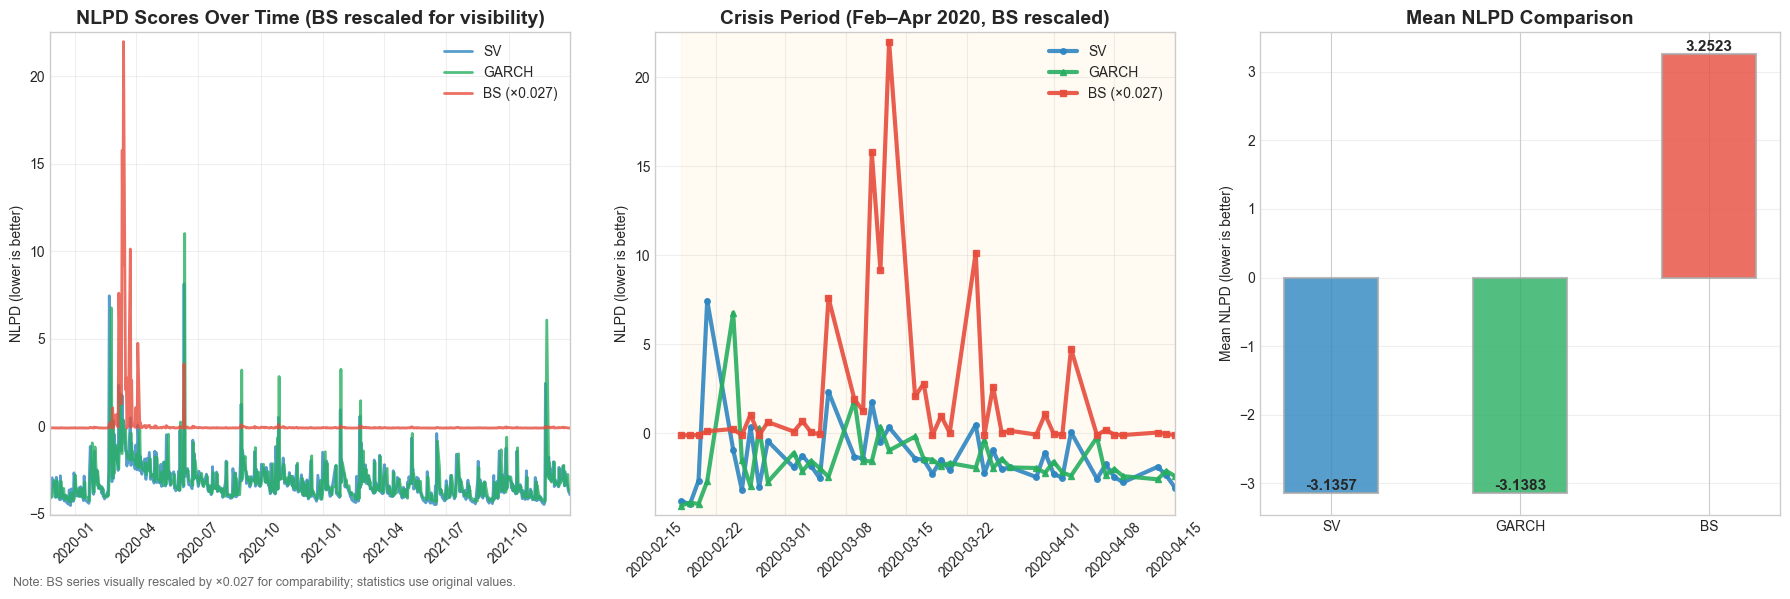


📊 Relative Performance:

📊 Summary Statistics:
SV - Min: -4.5321, Max: 8.1444, Std: 1.2320
GARCH - Min: -4.3165, Max: 11.0193, Std: 1.3211
BS - Min: -3.9119, Max: 820.9864, Std: 52.4296

✅ Three-way NLPD analysis completed!


In [23]:
# =============================================================================
# THREE-WAY NLPD COMPARISON (SV vs GARCH vs BS) — with BS p99 rescaling
# =============================================================================

def plot_three_way_nlpd_comparison(sv_nlpd, garch_nlpd, bs_nlpd, test_data_decimal):
    """
    Create comprehensive NLPD comparison for SV, GARCH, and Black-Scholes models
    """
    # Debug: Check initial lengths
    print(f"Initial lengths - SV: {len(sv_nlpd)}, GARCH: {len(garch_nlpd)}, BS: {len(bs_nlpd)}")
    
    # Convert to numpy arrays and flatten if needed
    sv_array = np.array(sv_nlpd).flatten()
    garch_array = np.array(garch_nlpd).flatten()
    bs_array = np.array(bs_nlpd).flatten()
    
    # Remove any NaN or infinite values
    sv_clean = sv_array[np.isfinite(sv_array)]
    garch_clean = garch_array[np.isfinite(garch_array)]
    bs_clean = bs_array[np.isfinite(bs_array)]
    
    print(f"After cleaning - SV: {len(sv_clean)}, GARCH: {len(garch_clean)}, BS: {len(bs_clean)}")
    
    # Align all to same length (minimum)
    min_length = min(len(sv_clean), len(garch_clean), len(bs_clean))
    if min_length == 0:
        print("❌ Error: No valid NLPD scores to compare")
        return None
    
    sv_aligned = sv_clean[:min_length]
    garch_aligned = garch_clean[:min_length]
    bs_aligned = bs_clean[:min_length]
    
    print(f"Final aligned length: {min_length}")
    
    # Calculate means (true, unscaled)
    sv_mean = np.mean(sv_aligned)
    garch_mean = np.mean(garch_aligned)
    bs_mean = np.mean(bs_aligned)
    
    print("\n" + "="*60)
    print("📊 THREE-WAY NLPD COMPARISON RESULTS")
    print("="*60)
    print(f"Stochastic Volatility: {sv_mean:.4f}")
    print(f"GARCH(1,1):           {garch_mean:.4f}")
    print(f"Black-Scholes:        {bs_mean:.4f}")
    print("-"*40)
    
    # Rank models
    models_scores = [('SV', sv_mean), ('GARCH', garch_mean), ('BS', bs_mean)]
    models_scores.sort(key=lambda x: x[1])
    print("Ranking (best to worst):")
    for i, (model, score) in enumerate(models_scores, 1):
        print(f"  {i}. {model}: {score:.4f}")
    
    # Statistical tests (paired, unscaled)
    if min_length > 1:
        print("\n📊 Pairwise Statistical Tests:")
        try:
            t_stat, p_val = stats.ttest_rel(sv_aligned, garch_aligned)
            print(f"SV vs GARCH: p-value = {p_val:.4f}")
            if p_val < 0.05:
                winner = "SV" if sv_mean < garch_mean else "GARCH"
                print(f"  → {winner} is significantly better")
        except Exception as e:
            print(f"SV vs GARCH: Could not compute (error: {e})")
        try:
            t_stat, p_val = stats.ttest_rel(sv_aligned, bs_aligned)
            print(f"SV vs BS: p-value = {p_val:.4f}")
            if p_val < 0.05:
                winner = "SV" if sv_mean < bs_mean else "BS"
                print(f"  → {winner} is significantly better")
        except Exception as e:
            print(f"SV vs BS: Could not compute (error: {e})")
        try:
            t_stat, p_val = stats.ttest_rel(garch_aligned, bs_aligned)
            print(f"GARCH vs BS: p-value = {p_val:.4f}")
            if p_val < 0.05:
                winner = "GARCH" if garch_mean < bs_mean else "BS"
                print(f"  → {winner} is significantly better")
        except Exception as e:
            print(f"GARCH vs BS: Could not compute (error: {e})")
    else:
        print("\n⚠️ Not enough data points for statistical tests")
    
    # ---------- BS p99 visual rescaling ----------
    def spread_scale(x, y, q=99):
        xq = np.percentile(np.abs(x), q)
        yq = np.percentile(np.abs(y), q)
        if yq == 0:
            return 1.0
        return xq / yq
    
    target = np.concatenate([sv_aligned, garch_aligned])
    scale_bs = spread_scale(target, bs_aligned, q=99)
    scale_bs = min(scale_bs, 1.0)  # only shrink, never amplify
    bs_aligned_vis = bs_aligned * scale_bs
    print(f"BS visual scaling factor (p99 match): ×{scale_bs:.3g}")
    # ---------------------------------------------
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define colors
    sv_color = '#2E86C1'
    garch_color = '#27AE60'
    bs_color = '#E74C3C'
    
    # Get dates for plotting
    dates = test_data_decimal.index[:min_length]
    
    # Plot 1: Full period (scaled BS)
    axes[0].plot(dates, sv_aligned,     color=sv_color,   linewidth=2, label='SV',    alpha=0.8)
    axes[0].plot(dates, garch_aligned,  color=garch_color, linewidth=2, label='GARCH', alpha=0.8)
    axes[0].plot(dates, bs_aligned_vis, color=bs_color,    linewidth=2, label=f'BS (×{scale_bs:.2g})', alpha=0.8)
    
    axes[0].set_xlim(dates.min(), dates.max())
    y_min = min(sv_aligned.min(), garch_aligned.min(), bs_aligned_vis.min())
    y_max = max(sv_aligned.max(), garch_aligned.max(), bs_aligned_vis.max())
    pad = 0.02 * (y_max - y_min) if y_max > y_min else 1.0
    axes[0].set_ylim(y_min - pad, y_max + pad)
    
    axes[0].set_title('NLPD Scores Over Time (BS rescaled for visibility)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('NLPD (lower is better)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Crisis period zoom (scaled BS)
    zoom_start = pd.to_datetime('2020-02-15')
    zoom_end = pd.to_datetime('2020-04-15')
    zoom_mask = (dates >= zoom_start) & (dates <= zoom_end)
    
    if zoom_mask.any():
        zoom_indices = np.where(zoom_mask)[0]
        zoom_dates = dates[zoom_mask]
        sv_zoom = sv_aligned[zoom_indices]
        garch_zoom = garch_aligned[zoom_indices]
        bs_zoom_vis = bs_aligned_vis[zoom_indices]
        
        axes[1].plot(zoom_dates, sv_zoom,     color=sv_color,   linewidth=3, label='SV',    alpha=0.9, marker='o', markersize=4)
        axes[1].plot(zoom_dates, garch_zoom,  color=garch_color, linewidth=3, label='GARCH', alpha=0.9, marker='^', markersize=4)
        axes[1].plot(zoom_dates, bs_zoom_vis, color=bs_color,    linewidth=3, label=f'BS (×{scale_bs:.2g})', alpha=0.9, marker='s', markersize=4)
        
        axes[1].set_xlim(zoom_start, zoom_end)
        y_min = min(sv_zoom.min(), garch_zoom.min(), bs_zoom_vis.min())
        y_max = max(sv_zoom.max(), garch_zoom.max(), bs_zoom_vis.max())
        pad = 0.02 * (y_max - y_min) if y_max > y_min else 1.0
        axes[1].set_ylim(y_min - pad, y_max + pad)
        
        axes[1].set_title('Crisis Period (Feb–Apr 2020, BS rescaled)', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('NLPD (lower is better)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].axvspan(zoom_dates.min(), zoom_dates.max(), alpha=0.05, color='orange')
    else:
        axes[1].text(0.5, 0.5, 'No data in crisis period', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Crisis Period (Feb–Apr 2020, BS rescaled)', fontsize=14, fontweight='bold')
    
    # Plot 3: Mean NLPD (unscaled)
    models = ['SV', 'GARCH', 'BS']
    means = [sv_mean, garch_mean, bs_mean]
    colors = [sv_color, garch_color, bs_color]
    
    bars = axes[2].bar(models, means, color=colors, alpha=0.8, width=0.5, edgecolor='darkgray', linewidth=1.5)
    axes[2].set_title('Mean NLPD Comparison', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Mean NLPD (lower is better)')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    for bar, mean_val in zip(bars, means):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height, f'{mean_val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    fig.text(0.01, 0.01, f'Note: BS series visually rescaled by ×{scale_bs:.2g} for comparability; statistics use original values.',
             fontsize=9, ha='left', va='bottom', color='dimgray')
    
    plt.tight_layout()
    plt.show()
    
    # Relative improvements (unchanged)
    print("\n📊 Relative Performance:")
    best_model, best_score = models_scores[0]
    for model, score in models_scores[1:]:
        if score > 0 and best_score > 0:
            improvement = ((score - best_score) / score) * 100
            print(f"{best_model} vs {model}: {improvement:.1f}% improvement")
    
    # Summary statistics (unscaled)
    print("\n📊 Summary Statistics:")
    print(f"SV - Min: {np.min(sv_aligned):.4f}, Max: {np.max(sv_aligned):.4f}, Std: {np.std(sv_aligned):.4f}")
    print(f"GARCH - Min: {np.min(garch_aligned):.4f}, Max: {np.max(garch_aligned):.4f}, Std: {np.std(garch_aligned):.4f}")
    print(f"BS - Min: {np.min(bs_aligned):.4f}, Max: {np.max(bs_aligned):.4f}, Std: {np.std(bs_aligned):.4f}")
    
    return {
        'sv_nlpd': sv_aligned,
        'garch_nlpd': garch_aligned,
        'bs_nlpd': bs_aligned,
        'sv_mean': sv_mean,
        'garch_mean': garch_mean,
        'bs_mean': bs_mean,
        'min_length': min_length,
        'scale_bs': scale_bs
    }


# Run the three-way comparison
print("\n📊 Running three-way NLPD comparison...")
nlpd_comparison_full = plot_three_way_nlpd_comparison(
    sv_nlpd_scores, 
    garch_nlpd_scores, 
    bs_nlpd_scores, 
    test_data_decimal
)

if nlpd_comparison_full:
    print("\n✅ Three-way NLPD analysis completed!")
else:
    print("\n❌ Three-way NLPD analysis failed - check data")

### Spikes analysis


📊 Step 7: Running enhanced NLPD spike analysis...
🔍 ANALYZING NLPD SPIKES (threshold = 2.0)
SV Model spikes above 2.0: 4 days
BS Model spikes above 2.0: 26 days
Either model spikes: 27 days

📅 SPIKE DATES AND DETAILS:
--------------------------------------------------------------------------------
2020-02-21 | Return:  -0.01% | SV NLPD:   7.46 | BS NLPD:   4.75
2020-02-24 | Return:  -0.03% | SV NLPD:  -0.91 | BS NLPD:   9.43
2020-02-26 | Return:  -0.00% | SV NLPD:   0.35 | BS NLPD:  39.52
2020-02-28 | Return:  -0.00% | SV NLPD:  -0.43 | BS NLPD:  23.94
2020-03-02 | Return:   0.04% | SV NLPD:  -1.90 | BS NLPD:   4.02
2020-03-03 | Return:  -0.03% | SV NLPD:  -1.24 | BS NLPD:  25.78
2020-03-04 | Return:   0.04% | SV NLPD:  -1.82 | BS NLPD:   2.09
2020-03-06 | Return:  -0.02% | SV NLPD:   2.35 | BS NLPD: 284.22
2020-03-09 | Return:  -0.08% | SV NLPD:  -1.30 | BS NLPD:  71.35
2020-03-10 | Return:   0.05% | SV NLPD:  -1.41 | BS NLPD:  47.32
2020-03-11 | Return:  -0.05% | SV NLPD:   1.76 | BS

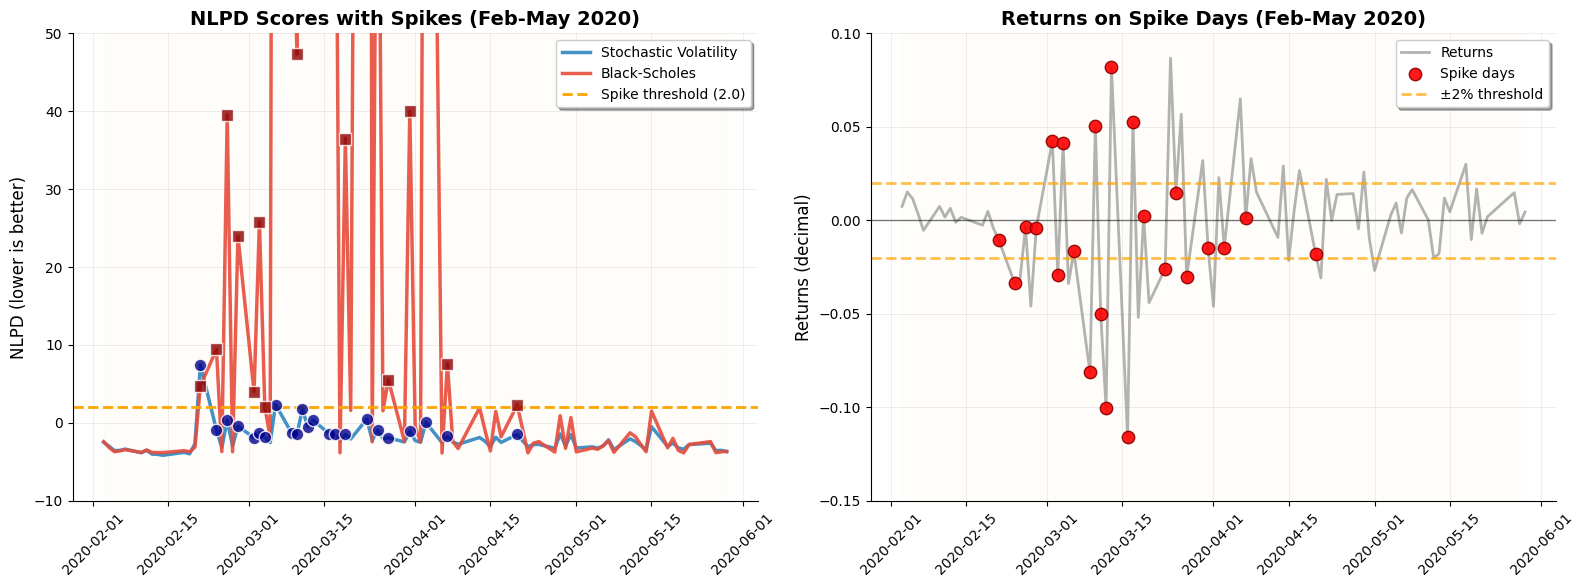

✅ Spike analysis completed


In [24]:
# =============================================================================
# ENHANCED NLPD SPIKE ANALYSIS FUNCTIONS
# =============================================================================

def analyze_nlpd_spikes(sv_nlpd_scores, bs_nlpd_scores, test_data_decimal, threshold=2.0):
    """
    Analyze NLPD spikes and identify problematic dates
    
    Parameters:
    -----------
    sv_nlpd_scores : list
        NLPD scores for Stochastic Volatility model
    bs_nlpd_scores : list
        NLPD scores for Black-Scholes model
    test_data_decimal : pd.DataFrame
        Test data with dates and returns
    threshold : float, default=2.0
        Threshold for identifying spikes
        
    Returns:
    --------
    list : Spike data information
    """
    # Align data
    min_length = min(len(sv_nlpd_scores), len(bs_nlpd_scores))
    sv_aligned = np.array(sv_nlpd_scores[:min_length]).flatten()
    bs_aligned = np.array(bs_nlpd_scores[:min_length]).flatten()
    dates = test_data_decimal.index[:min_length]
    returns = test_data_decimal['Returns'].values[:min_length]
    
    print(f"🔍 ANALYZING NLPD SPIKES (threshold = {threshold})")
    print("="*60)
    
    # Find spikes for both models
    sv_spikes = sv_aligned > threshold
    bs_spikes = bs_aligned > threshold
    any_spikes = sv_spikes | bs_spikes
    
    print(f"SV Model spikes above {threshold}: {np.sum(sv_spikes)} days")
    print(f"BS Model spikes above {threshold}: {np.sum(bs_spikes)} days")
    print(f"Either model spikes: {np.sum(any_spikes)} days")
    
    if np.sum(any_spikes) > 0:
        print(f"\n📅 SPIKE DATES AND DETAILS:")
        print("-"*80)
        
        spike_data = []
        # Use boolean indexing correctly
        spike_indices = np.where(any_spikes)[0]
        
        for idx in spike_indices:
            date = dates[idx]
            ret = float(returns[idx])  # Convert to scalar
            sv_nlpd = float(sv_aligned[idx])  # Convert to scalar
            bs_nlpd = float(bs_aligned[idx])  # Convert to scalar
            
            spike_info = {
                'date': date,
                'return': ret,
                'sv_nlpd': sv_nlpd,
                'bs_nlpd': bs_nlpd,
                'abs_return': abs(ret)
            }
            spike_data.append(spike_info)
            
            print(f"{date.strftime('%Y-%m-%d')} | Return: {ret:6.2f}% | "
                  f"SV NLPD: {sv_nlpd:6.2f} | BS NLPD: {bs_nlpd:6.2f}")
        
        # Sort by highest NLPD
        spike_data.sort(key=lambda x: max(x['sv_nlpd'], x['bs_nlpd']), reverse=True)
        
        print(f"\n🚨 TOP 5 WORST NLPD DAYS:")
        print("-"*50)
        for i, spike in enumerate(spike_data[:5]):
            worst_nlpd = max(spike['sv_nlpd'], spike['bs_nlpd'])
            worst_model = "SV" if spike['sv_nlpd'] > spike['bs_nlpd'] else "BS"
            print(f"{i+1}. {spike['date'].strftime('%Y-%m-%d')} | "
                  f"Return: {spike['return']:6.2f}% | "
                  f"Worst NLPD: {worst_nlpd:.2f} ({worst_model})")
        
        # Analyze correlation with extreme returns
        extreme_returns = np.abs(returns) > 2  # |returns| > 2%
        spike_on_extreme = any_spikes & extreme_returns
        
        print(f"\n📊 SPIKE ANALYSIS:")
        print("-"*30)
        print(f"Days with |returns| > 2%: {np.sum(extreme_returns)}")
        print(f"Spikes on extreme return days: {np.sum(spike_on_extreme)}")
        if np.sum(extreme_returns) > 0:
            print(f"% of extreme days with spikes: {np.sum(spike_on_extreme)/np.sum(extreme_returns)*100:.1f}%")
        if np.sum(any_spikes) > 0:
            print(f"% of spikes on extreme days: {np.sum(spike_on_extreme)/np.sum(any_spikes)*100:.1f}%")
    else:
        print(f"\n✅ No spikes found above threshold {threshold}")
        spike_data = []
    
    # Set style for better aesthetics
    plt.style.use('default')
    plt.rcParams.update({
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'legend.fontsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.5
    })
    
    # Create visualization with only 2 plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.patch.set_facecolor('white')
    
    # Define colors
    sv_color = '#2E86C1'  # Professional blue
    bs_color = '#E74C3C'  # Professional red
    
    # Define zoom period (February to May 2020)
    zoom_start = pd.to_datetime('2020-02-01')
    zoom_end = pd.to_datetime('2020-05-31')
    zoom_mask = (dates >= zoom_start) & (dates <= zoom_end)
    
    # Plot 1: NLPD time series with spike threshold (ZOOMED)
    if zoom_mask.any():
        zoom_dates = dates[zoom_mask]
        sv_zoom = sv_aligned[zoom_mask]
        bs_zoom = bs_aligned[zoom_mask]
        returns_zoom = returns[zoom_mask]
        any_spikes_zoom = any_spikes[zoom_mask]
        
        axes[0].plot(zoom_dates, sv_zoom, color=sv_color, linewidth=2.5, 
                    alpha=0.9, label='Stochastic Volatility')
        axes[0].plot(zoom_dates, bs_zoom, color=bs_color, linewidth=2.5, 
                    alpha=0.9, label='Black-Scholes')
        axes[0].axhline(y=threshold, color='orange', linestyle='--', linewidth=2,
                       label=f'Spike threshold ({threshold})')
        
        if np.sum(any_spikes_zoom) > 0:
            spike_indices_zoom = np.where(any_spikes_zoom)[0]
            axes[0].scatter(zoom_dates[spike_indices_zoom], sv_zoom[spike_indices_zoom], 
                           color='darkblue', s=80, alpha=0.8, zorder=5, marker='o', edgecolor='white')
            axes[0].scatter(zoom_dates[spike_indices_zoom], bs_zoom[spike_indices_zoom], 
                           color='darkred', s=80, alpha=0.8, zorder=5, marker='s', edgecolor='white')
        
        axes[0].set_title('NLPD Scores with Spikes (Feb-May 2020)', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('NLPD (lower is better)', fontsize=12)
        axes[0].legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
        axes[0].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].set_ylim(-10, 50)  # Zoom y-axis from -10 to 100
        
        # Plot 2: Returns on spike days (ZOOMED)
        axes[1].plot(zoom_dates, returns_zoom, color='gray', alpha=0.6, linewidth=2, 
                    label='Returns')
        
        if np.sum(any_spikes_zoom) > 0:
            spike_indices_zoom = np.where(any_spikes_zoom)[0]
            axes[1].scatter(zoom_dates[spike_indices_zoom], returns_zoom[spike_indices_zoom], 
                           color='red', s=80, alpha=0.9, label='Spike days', zorder=5, 
                           marker='o', edgecolor='darkred', linewidth=1)
        
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
        axes[1].axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='±2% threshold')
        axes[1].axhline(y=-0.02, color='orange', linestyle='--', alpha=0.7, linewidth=2)
        axes[1].set_title('Returns on Spike Days (Feb-May 2020)', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Returns (decimal)', fontsize=12)
        axes[1].legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
        axes[1].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].set_ylim(-0.15, 0.1)  # Zoom y-axis from -0.1 to 0.1 (10%)
        
        # Add subtle shading to both plots
        for ax in axes:
            ax.axvspan(zoom_dates.min(), zoom_dates.max(), alpha=0.02, color='orange')
    
    else:
        # Fallback if no data in zoom period
        for i, ax in enumerate(axes):
            ax.text(0.5, 0.5, 'No data available\nfor zoom period', 
                    ha='center', va='center', transform=ax.transAxes, 
                    fontsize=12, style='italic')
            if i == 0:
                ax.set_title('NLPD Scores with Spikes (Feb-May 2020)', fontsize=14, fontweight='bold')
            else:
                ax.set_title('Returns on Spike Days (Feb-May 2020)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return spike_data

# =============================================================================
# SPIKE ANALYSIS EXECUTION
# =============================================================================

print("📊 Step 7: Running enhanced NLPD spike analysis...")
spike_analysis = analyze_nlpd_spikes(sv_nlpd_scores, bs_nlpd_scores, test_data_decimal, threshold=2.0)
print("✅ Spike analysis completed")

# Bayes Factor

In [25]:
# =========================
# SV: priors, PF likelihood, Chib marginal (your originals)
# =========================
def log_prior_sv(mu, logit_phi, sigma_x):
    logp = norm.logpdf(mu, loc=0, scale=2.0)
    logp += norm.logpdf(logit_phi, loc=2.94, scale=1.0)
    logp += invgamma.logpdf(sigma_x, a=3, scale=0.5)
    return logp

def estimate_log_lik_sv(y, mu, logit_phi, sigma_x, N=10000):
    model = StochasticVolatilityModel(mu=mu, logit_phi=logit_phi, sigma_x=sigma_x)
    fk = Bootstrap(ssm=model, data=y)
    pf = SMC(fk=fk, N=N, ESSrmin=0.5, resampling='stratified')
    pf.run()
    return pf.logLt

def log_marginal_sv(y, mcmc_results, N_pf=10000):
    samples = mcmc_results['mcmc'].get_samples()
    n_burn = 500

    mu_samples = samples['mu']
    logit_phi_samples = samples['logit_phi']
    sigma_x_samples = samples['sigma_x']
    
    if mu_samples.ndim == 1:
        burned_mu = mu_samples[n_burn:]
        burned_logit_phi = logit_phi_samples[n_burn:]
        burned_sigma_x = sigma_x_samples[n_burn:]
    else:
        burned_mu = mu_samples[:, n_burn:].flatten()
        burned_logit_phi = logit_phi_samples[:, n_burn:].flatten()
        burned_sigma_x = sigma_x_samples[:, n_burn:].flatten()
    
    mu_star = np.mean(burned_mu)
    logit_phi_star = np.mean(burned_logit_phi)
    sigma_x_star = np.mean(burned_sigma_x)
    
    log_lik = estimate_log_lik_sv(y, mu_star, logit_phi_star, sigma_x_star, N=N_pf)
    log_prior = log_prior_sv(mu_star, logit_phi_star, sigma_x_star)
    
    samples_stack = np.vstack((burned_mu, burned_logit_phi, burned_sigma_x))
    kde = gaussian_kde(samples_stack)
    theta_star = np.array([mu_star, logit_phi_star, sigma_x_star])
    log_post = float(kde.logpdf(theta_star))
    
    return float(log_lik + log_prior - log_post)

# =========================
# BS: closed-form marginal (your original)
# =========================
def log_marginal_bs(y, mu0=0, nu=1, alpha=3, beta=0.5):
    n = len(y)
    if n == 0:
        return 0.0
    x_bar = np.mean(y)
    sum_sq_dev = np.sum((y - x_bar)**2)
    nu_post = nu + n
    alpha_post = alpha + n / 2.0
    beta_post = beta + 0.5 * sum_sq_dev + (n * nu * (x_bar - mu0)**2) / (2.0 * (nu + n))
    log_marg = (
        - (n / 2.0) * np.log(2 * np.pi) +
        gammaln(alpha_post) - gammaln(alpha) +
        alpha * np.log(beta) - alpha_post * np.log(beta_post) +
        0.5 * np.log(nu / nu_post)
    )
    return float(log_marg)

# =========================
# GARCH(1,1): full Bayesian (Chib) aligned with your NumPyro model
# =========================

def _garch11_loglik_zero_mean(y, omega, alpha, beta):
    """
    Gaussian GARCH(1,1) log-likelihood with zero mean:
        h_t = omega + alpha * y_{t-1}^2 + beta * h_{t-1}
        y_t ~ N(0, h_t)
    """
    y = np.asarray(y)
    n = len(y)
    eps = 1e-12
    # h0: unconditional variance if stationary, else sample variance
    if (alpha + beta) < 1.0 and omega > 0:
        h_prev = omega / max(1.0 - alpha - beta, eps)
    else:
        v = np.var(y)
        h_prev = v if v > eps else 1.0

    ll = 0.0
    for t in range(n):
        e_prev_sq = y[t-1]**2 if t > 0 else 0.0
        h_t = omega + alpha * e_prev_sq + beta * h_prev
        if h_t <= eps:
            h_t = eps
        ll += -0.5 * (np.log(2*np.pi) + np.log(h_t) + (y[t]**2)/h_t)
        h_prev = h_t
    return ll

def _log_prior_garch_numpyro(omega, alpha, beta, low=1e-6, high=0.01):
    """
    Priors exactly as in your NumPyro model + stationarity soft barrier.
      omega ~ Uniform(low, high)
      alpha ~ Beta(2,5)
      beta  ~ Beta(5,2)
      stationarity penalty: 0 if alpha+beta<0.999, else -100*(alpha+beta-0.999)^2
    """
    # Uniform on (low, high)
    if not (low < omega < high):
        return -np.inf
    logp_omega = -np.log(high - low)

    # Betas on (0,1)
    if not (0 < alpha < 1) or not (0 < beta < 1):
        return -np.inf
    logp_alpha = beta_dist.logpdf(alpha, a=2, b=5)
    logp_beta  = beta_dist.logpdf(beta,  a=5, b=2)

    # Soft barrier for stationarity to mirror numpyro.factor
    penalty = 0.0 if (alpha + beta) < 0.999 else -100.0 * (alpha + beta - 0.999)**2
    return logp_omega + logp_alpha + logp_beta + penalty

def log_marginal_garch_numpyro_chib(y, garch_results):
    """
    Chib-style log marginal likelihood for your NumPyro GARCH(1,1).
    Expects garch_results from bayesian_garch_estimation_numpyro(...)
    Uses KDE in unconstrained space and corrects with the Jacobian.
    """
    # Get samples (NumPy array)
    if 'samples' in garch_results:
        s = garch_results['samples']
    else:
        s = garch_results['mcmc'].get_samples()

    omega_s = np.asarray(s['omega']).reshape(-1)
    alpha_s = np.asarray(s['alpha']).reshape(-1)
    beta_s  = np.asarray(s['beta']).reshape(-1)

    # Posterior point theta* (means)
    omega_star = float(np.mean(omega_s))
    alpha_star = float(np.mean(alpha_s))
    beta_star  = float(np.mean(beta_s))

    # 1) Log-likelihood at theta*
    log_lik = _garch11_loglik_zero_mean(y, omega_star, alpha_star, beta_star)

    # 2) Log prior at theta*
    log_prior = _log_prior_garch_numpyro(omega_star, alpha_star, beta_star)

    # 3) Posterior ordinate via KDE in unconstrained space
    #    u = log(omega), v = logit(alpha), w = logit(beta)
    def logit(p): return np.log(p) - np.log(1.0 - p)
    u = np.log(omega_s)
    v = logit(alpha_s)
    w = logit(beta_s)
    kde = gaussian_kde(np.vstack([u, v, w]))
    u_star = np.log(omega_star)
    v_star = logit(alpha_star)
    w_star = logit(beta_star)
    log_post_trans = float(kde.logpdf([u_star, v_star, w_star]))

    # Transform back to original space: f(theta) = g(z) / |d z / d theta|
    # log |d z / d theta| = log(1/omega) + log(1/(alpha*(1-alpha))) + log(1/(beta*(1-beta)))
    # so: log f(theta) = log g(z) - [ -log(omega) - log(alpha(1-alpha)) - log(beta(1-beta)) ]
    # equivalently subtract log-Jacobian of inverse transform:
    jac = np.log(omega_star) + np.log(alpha_star*(1.0 - alpha_star)) + np.log(beta_star*(1.0 - beta_star))
    log_post = log_post_trans - jac

    return float(log_lik + log_prior - log_post)

# =========================
# All pairwise Bayes factors (full Bayesian)
# =========================
def compute_log_bf_all_full_bayes(
    y,
    mcmc_results_sv,
    garch_results,
    mu0_bs=0, nu_bs=1, alpha_bs=3, beta_bs=0.5,
    N_pf=10000
):
    """
    Computes log marginal likelihoods for SV (Chib+PF), BS (closed form),
    and GARCH(1,1) (Chib), then returns all pairwise log Bayes factors.
    """
    y = np.asarray(y)
    log_m_sv    = float(log_marginal_sv(y, mcmc_results_sv, N_pf=N_pf))
    log_m_bs    = float(log_marginal_bs(y, mu0=mu0_bs, nu=nu_bs, alpha=alpha_bs, beta=beta_bs))
    log_m_garch = float(log_marginal_garch_numpyro_chib(y, garch_results))

    out = {
        "log_marginals": {"SV": log_m_sv, "BS": log_m_bs, "GARCH": log_m_garch},
        "log_BF": {
            "SV_vs_BS":     float(log_m_sv - log_m_bs),
            "SV_vs_GARCH":  float(log_m_sv - log_m_garch),
            "GARCH_vs_BS":  float(log_m_garch - log_m_bs)
        }
    }
    return out



In [26]:
# =========================
# Example call
# =========================
y = np.concatenate((returns_train_decimal.values, returns_test_decimal.values))
res = compute_log_bf_all_full_bayes(
    y,
    mcmc_results_sv=mcmc_results,     # your existing SV MCMC result
    garch_results=garch_results,      # from bayesian_garch_estimation_numpyro(...)
    N_pf=10000
)
print(res)
print(f"Log BF (SV over BS):     {res['log_BF']['SV_vs_BS']:.3f}")
print(f"Log BF (SV over GARCH):  {res['log_BF']['SV_vs_GARCH']:.3f}")
print(f"Log BF (GARCH over BS):  {res['log_BF']['GARCH_vs_BS']:.3f}")


{'log_marginals': {'SV': 5995.633699830589, 'BS': 3922.0628195647582, 'GARCH': 5947.10662008424}, 'log_BF': {'SV_vs_BS': 2073.5708802658305, 'SV_vs_GARCH': 48.527079746349045, 'GARCH_vs_BS': 2025.0438005194815}}
Log BF (SV over BS):     2073.571
Log BF (SV over GARCH):  48.527
Log BF (GARCH over BS):  2025.044
